In [1]:
!pip install pycaret

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

from pycaret.classification import *

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from scipy.stats import ks_2samp

from sklearn.metrics import roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error, roc_auc_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import cross_val_predict, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

pd.set_option('display.max_columns', None)

In [3]:
loan_data = pd.read_csv('/content/drive/MyDrive/Datasets/loan_data_2007_2014.csv')
print("Load loan dataset succeed!")

Load loan dataset succeed!


In [4]:
loan_data.drop(loan_data.columns[0], axis=1, inplace=True)
loan_data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-85,1.0,NaN,NaN,3.0,0.0,13648,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,Jan-15,171.62,NaN,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-11,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-99,5.0,NaN,NaN,3.0,0.0,1687,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-13,119.66,NaN,Sep-13,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,small_business,real estate business,606xx,IL,8.72,0.0,Nov-01,2.0,NaN,NaN,2.0,0.0,2956,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,Jun-14,649.91,NaN,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0.0,Feb-96,1.0,35.0,NaN,10.0,0.0,5598,21.0,37.0,f,0.0,0.0,12226.302210,12226.30,10000.00,2209.33,16.97,0.00,0.00,Jan-15,357.48,NaN,Jan-15,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-11,Current,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > I plan on combi...,other,Personal,972xx,OR,17.94,0.0,Jan-96,0.0,38.0,NaN,15.0,0.0,27783,53.9,38.0,f,766.9,766.9,3242.170000,3242.17,2233.10,1009.07,0.00,0.00,0.00,Jan-16,67.79,Feb-16,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Data Understanding

In [5]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 74 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           466285 non-null  int64  
 1   member_id                    466285 non-null  int64  
 2   loan_amnt                    466285 non-null  int64  
 3   funded_amnt                  466285 non-null  int64  
 4   funded_amnt_inv              466285 non-null  float64
 5   term                         466285 non-null  object 
 6   int_rate                     466285 non-null  float64
 7   installment                  466285 non-null  float64
 8   grade                        466285 non-null  object 
 9   sub_grade                    466285 non-null  object 
 10  emp_title                    438697 non-null  object 
 11  emp_length                   445277 non-null  object 
 12  home_ownership               466285 non-null  object 
 13 

In [6]:
nums = []
cats = []

for feature in loan_data.columns:
    if loan_data[feature].dtype == 'object':
        cats.append(feature)
    else:
        nums.append(feature)

print("number of numerical features: ", len(nums))
print("number of categorical features: ", len(cats))

number of numerical features:  52
number of categorical features:  22


## Missing Value

In [ ]:
null_col = [col for col in loan_data.columns if loan_data[col].isnull().all()]
print("non-null columns:")
print(null_col)
print("\nnumber of non-null columns:")
print(len(null_col), "columns")

non-null columns:
['annual_inc_joint', 'dti_joint', 'verification_status_joint', 'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl', 'inq_last_12m']

number of non-null columns:
17 columns


In [ ]:
print("dataframe shape before dropped columns: ", loan_data.shape)

df = loan_data.drop(columns=null_col, axis=1)

print("dataframe shape after dropped columns: ", df.shape)

dataframe shape before dropped columns:  (466285, 74)
dataframe shape after dropped columns:  (466285, 57)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 57 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           466285 non-null  int64  
 1   member_id                    466285 non-null  int64  
 2   loan_amnt                    466285 non-null  int64  
 3   funded_amnt                  466285 non-null  int64  
 4   funded_amnt_inv              466285 non-null  float64
 5   term                         466285 non-null  object 
 6   int_rate                     466285 non-null  float64
 7   installment                  466285 non-null  float64
 8   grade                        466285 non-null  object 
 9   sub_grade                    466285 non-null  object 
 10  emp_title                    438697 non-null  object 
 11  emp_length                   445277 non-null  object 
 12  home_ownership               466285 non-null  object 
 13 

In [ ]:
null_percentage = round((df.isnull().sum() * 100) / len(df), 2)
df_null = pd.DataFrame({'null_percentage': null_percentage})
df_null.sort_values('null_percentage', ascending=False, inplace=True)
df_null = df_null[df_null['null_percentage'] > 0]
df_null

,null_percentage
mths_since_last_record,86.57
mths_since_last_major_derog,78.77
desc,72.98
mths_since_last_delinq,53.69
next_pymnt_d,48.73
tot_cur_bal,15.07
tot_coll_amt,15.07
total_rev_hi_lim,15.07
emp_title,5.92
emp_length,4.51


## Duplicated Data

In [ ]:
duplicated_data = df.duplicated().sum()

print("number of duplicated data:")
if duplicated_data > 0:
    print(duplicated_data, "data")
else:
    print("there is no duplicated data")

number of duplicated data:
there is no duplicated data


# Data Preparation

## Removing unused columns

In [ ]:
print("dataframe shape before dropped columns: ", df.shape)

df = df[df.columns[~df.columns.isin(['emp_title', 'url', 'desc', 'title', 'zip_code', 'addr_state', 'application_type'])]]

print("dataframe shape after dropped columns: ", df.shape)

dataframe shape before dropped columns:  (466285, 57)
dataframe shape after dropped columns:  (466285, 50)


## Handling Missing Values

### Removing `mths_since_last_record`, `mths_since_last_major_derog`, `mths_since_last_delinq` and `next_pymnt_d`

In [ ]:
print("dataframe shape before dropped columns: ", df.shape)

df = df[df.columns[~df.columns.isin(['mths_since_last_record', 'mths_since_last_major_derog', 'mths_since_last_delinq', 'next_pymnt_d'])]]

print("dataframe shape after dropped columns: ", df.shape)

dataframe shape before dropped columns:  (466285, 50)
dataframe shape after dropped columns:  (466285, 46)


### Imputation

In [ ]:
def impute_missing(df):
    """
    Impute missing values in a DataFrame.

    Parameters:
    df (DataFrame): Input DataFrame with missing values.

    Returns:
    DataFrame: DataFrame with missing values imputed.
    """
    # Separate categorical and numerical columns
    cat_cols = df.select_dtypes(include=['object']).columns
    num_cols = df.select_dtypes(include=['number']).columns

    # Impute categorical columns with mode
    for col in cat_cols:
        df[col].fillna(df[col].mode()[0], inplace=True)

    # Impute numerical columns with median
    for col in num_cols:
        df[col].fillna(df[col].median(), inplace=True)

    return df

In [ ]:
df = impute_missing(df)
print("Impute missing values succeed!")

Impute missing values succeed!


In [ ]:
df.isnull().sum()

id                            0
member_id                     0
loan_amnt                     0
funded_amnt                   0
funded_amnt_inv               0
term                          0
int_rate                      0
installment                   0
grade                         0
sub_grade                     0
emp_length                    0
home_ownership                0
annual_inc                    0
verification_status           0
issue_d                       0
loan_status                   0
pymnt_plan                    0
purpose                       0
dti                           0
delinq_2yrs                   0
earliest_cr_line              0
inq_last_6mths                0
open_acc                      0
pub_rec                       0
revol_bal                     0
revol_util                    0
total_acc                     0
initial_list_status           0
out_prncp                     0
out_prncp_inv                 0
total_pymnt                   0
total_py

## Checking Unique Values

In [ ]:
print("number of unique values from numeric columns:")
print(df.select_dtypes(exclude='object').nunique())

number of unique values from numeric columns:
id                            466285
member_id                     466285
loan_amnt                       1352
funded_amnt                     1354
funded_amnt_inv                 9854
int_rate                         506
installment                    55622
annual_inc                     31901
dti                             3997
delinq_2yrs                       24
inq_last_6mths                    28
open_acc                          62
pub_rec                           26
revol_bal                      58142
revol_util                      1269
total_acc                        112
out_prncp                     135665
out_prncp_inv                 141189
total_pymnt                   351609
total_pymnt_inv               347659
total_rec_prncp               172713
total_rec_int                 270249
total_rec_late_fee              5808
recoveries                     22773
collection_recovery_fee        20275
last_pymnt_amnt              



*   `id` and `member_id` have unique values ​​in each row
*   `policy_code` only have single unique value



In [ ]:
print("number of unique values from categorical columns:")
print(df.select_dtypes(include='object').nunique())

number of unique values from categorical columns:
term                     2
grade                    7
sub_grade               35
emp_length              11
home_ownership           6
verification_status      3
issue_d                 91
loan_status              9
pymnt_plan               2
purpose                 14
earliest_cr_line       664
initial_list_status      2
last_pymnt_d            98
last_credit_pull_d     103
dtype: int64




*   `earliest_cr_line` has more than 500 unique values
*   `issue_d`, `last_pymnt_d`, and `last_credit_pull_d` have at least more than 50 unique values (below 500)
*   `term`, `grade`, `sub_grade`, `emp-length`, `home_ownership`, `verification_status`, `loan_status`, `pymnt_plan`, `purpose`, `initial_list_status` has less than 50 unique values



In [ ]:
df['term'].unique()

array([' 36 months', ' 60 months'], dtype=object)



*   Because there is a whitespace, I need to remove it



In [ ]:
df['term'] = df['term'].apply(lambda x: x.strip())
print("Removing whitespace succeed!")
df['term'].unique()

Removing whitespace succeed!


array(['36 months', '60 months'], dtype=object)

In [ ]:
df['grade'].unique()

array(['B', 'C', 'A', 'E', 'F', 'D', 'G'], dtype=object)

In [ ]:
df['sub_grade'].unique()

array(['B2', 'C4', 'C5', 'C1', 'B5', 'A4', 'E1', 'F2', 'C3', 'B1', 'D1',
       'A1', 'B3', 'B4', 'C2', 'D2', 'A3', 'A5', 'D5', 'A2', 'E4', 'D3',
       'D4', 'F3', 'E3', 'F4', 'F1', 'E5', 'G4', 'E2', 'G3', 'G2', 'G1',
       'F5', 'G5'], dtype=object)

In [ ]:
df['emp_length'].unique()

array(['10+ years', '< 1 year', '1 year', '3 years', '8 years', '9 years',
       '4 years', '5 years', '6 years', '2 years', '7 years'],
      dtype=object)

In [ ]:
df['home_ownership'].unique()

array(['RENT', 'OWN', 'MORTGAGE', 'OTHER', 'NONE', 'ANY'], dtype=object)

In [ ]:
df['verification_status'].unique()

array(['Verified', 'Source Verified', 'Not Verified'], dtype=object)

In [ ]:
df['pymnt_plan'].unique()

array(['n', 'y'], dtype=object)

In [ ]:
df['purpose'].unique()

array(['credit_card', 'car', 'small_business', 'other', 'wedding',
       'debt_consolidation', 'home_improvement', 'major_purchase',
       'medical', 'moving', 'vacation', 'house', 'renewable_energy',
       'educational'], dtype=object)

In [ ]:
df['initial_list_status'].unique()

array(['f', 'w'], dtype=object)

## Creating Target Variable



*   `target` feature would be our y variable
*   The `target` feature will be created by doing feature engineering from the `loan_status` feature, so the `loan_status` feature can be dropped later



In [ ]:
df['loan_status'].unique()

array(['Fully Paid', 'Charged Off', 'Current', 'Default',
       'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)



*   Good Loan (1): `Fully Paid`, `Does not meet the credit policy. Status:Fully Paid`
*   Bad Loan (0): `Charged Off`, `Default`, `Late (31-120 days)`, `In Grace Period`, `Late (16-30 days)`, `Does not meet the credit policy. Status:Charged Off`
*   Does Not Meet Requirements for Both (-1): `Current`
*   The Good Loan (1) and the Bad Loan (0) later will be used for binary classification
*   Later, Undetachable Loan (-1) columns will be dropped because it is still current loan in progress that can not be detected as good or bad



In [ ]:
def create_target_variable(df, target_dict):
    """
    Create a new target variable based on the provided dictionary.

    Parameters:
    df (DataFrame): Input DataFrame containing the original status column.
    target_dict (dict): Dictionary mapping original status values to target values.

    Returns:
    DataFrame: DataFrame with the new target variable added.
    """
    # Create a new target variable based on the dictionary mapping
    df['target'] = df['loan_status'].map(target_dict)

    # Filter out rows where 'target' is not in [0, 1]
    df_filtered = df[df['target'].isin([0, 1])].reset_index(drop=True)

    return df_filtered

In [ ]:
target_dict = {'Fully Paid': 1,
               'Does not meet the credit policy. Status:Fully Paid': 1,
               'Charged Off': 0,
               'Default': 0,
               'Late (31-120 days)': 0,
               'In Grace Period': 0,
               'Late (16-30 days)': 0,
               'Does not meet the credit policy. Status:Charged Off': 0,
               'Current': -1}

df = create_target_variable(df, target_dict)
print("Creating target variable succeed!")

Creating target variable succeed!


In [ ]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,target
0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,10+ years,RENT,24000.0,Verified,Dec-11,Fully Paid,n,credit_card,27.65,0.0,Jan-85,1.0,3.0,0.0,13648,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,Jan-15,171.62,Jan-16,0.0,1,0.0,0.0,81539.0,22800.0,1
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,< 1 year,RENT,30000.0,Source Verified,Dec-11,Charged Off,n,car,1.00,0.0,Apr-99,5.0,3.0,0.0,1687,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-13,119.66,Sep-13,0.0,1,0.0,0.0,81539.0,22800.0,0
2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,10+ years,RENT,12252.0,Not Verified,Dec-11,Fully Paid,n,small_business,8.72,0.0,Nov-01,2.0,2.0,0.0,2956,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,Jun-14,649.91,Jan-16,0.0,1,0.0,0.0,81539.0,22800.0,1
3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,10+ years,RENT,49200.0,Source Verified,Dec-11,Fully Paid,n,other,20.00,0.0,Feb-96,1.0,10.0,0.0,5598,21.0,37.0,f,0.0,0.0,12226.302210,12226.30,10000.00,2209.33,16.97,0.00,0.00,Jan-15,357.48,Jan-15,0.0,1,0.0,0.0,81539.0,22800.0,1
4,1075269,1311441,5000,5000,5000.0,36 months,7.90,156.46,A,A4,3 years,RENT,36000.0,Source Verified,Dec-11,Fully Paid,n,wedding,11.20,0.0,Nov-04,3.0,9.0,0.0,7963,28.3,12.0,f,0.0,0.0,5631.377753,5631.38,5000.00,631.38,0.00,0.00,0.00,Jan-15,161.03,Sep-15,0.0,1,0.0,0.0,81539.0,22800.0,1


## Datetime Setting

In [ ]:
datetime_col = df[['earliest_cr_line', 'issue_d', 'last_pymnt_d', 'last_credit_pull_d']]

for col in datetime_col:
    print(col)
    print(datetime_col[col].value_counts())
    print("-----" * 10)

earliest_cr_line
Oct-00    2087
Oct-99    1910
Nov-00    1879
Oct-01    1870
Nov-99    1847
          ... 
Mar-65       1
Sep-56       1
Jan-46       1
Oct-11       1
Nov-56       1
Name: earliest_cr_line, Length: 634, dtype: int64
--------------------------------------------------
issue_d
Oct-14    10148
Jul-14     9605
Apr-14     7357
Dec-13     7055
May-14     7052
          ...  
Aug-07       74
Jul-07       63
Sep-08       57
Sep-07       53
Jun-07       24
Name: issue_d, Length: 91, dtype: int64
--------------------------------------------------
last_pymnt_d
Dec-15    12428
Jul-15    11703
Oct-15    11248
Sep-15    10204
Mar-15    10087
          ...  
Jun-08       20
Mar-08       18
Jan-08       11
Feb-08        8
Dec-07        2
Name: last_pymnt_d, Length: 98, dtype: int64
--------------------------------------------------
last_credit_pull_d
Jan-16    104823
Dec-15     13790
Nov-15      8238
Sep-15      7983
Oct-15      7852
           ...  
Nov-07         3
May-08         1
Ju

In [ ]:
# Set standard datetime
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], format='%b-%y')
df['issue_d'] = pd.to_datetime(df['issue_d'], format='%b-%y')
df['last_pymnt_d'] = pd.to_datetime(df['last_pymnt_d'], format='%b-%y')
df['last_credit_pull_d'] = pd.to_datetime(df['last_credit_pull_d'], format='%b-%y')
print("Formatting the datetime feature succeed!")

Formatting the datetime feature succeed!


In [ ]:
updated_datetime_col = df[['earliest_cr_line', 'issue_d', 'last_pymnt_d', 'last_credit_pull_d']]

for col in updated_datetime_col:
    print(col)
    print(updated_datetime_col[col].value_counts())
    print("-----" * 10)

earliest_cr_line
2000-10-01    2087
1999-10-01    1910
2000-11-01    1879
2001-10-01    1870
1999-11-01    1847
              ... 
2065-03-01       1
2056-09-01       1
2046-01-01       1
2011-10-01       1
2056-11-01       1
Name: earliest_cr_line, Length: 634, dtype: int64
--------------------------------------------------
issue_d
2014-10-01    10148
2014-07-01     9605
2014-04-01     7357
2013-12-01     7055
2014-05-01     7052
              ...  
2007-08-01       74
2007-07-01       63
2008-09-01       57
2007-09-01       53
2007-06-01       24
Name: issue_d, Length: 91, dtype: int64
--------------------------------------------------
last_pymnt_d
2015-12-01    12428
2015-07-01    11703
2015-10-01    11248
2015-09-01    10204
2015-03-01    10087
              ...  
2008-06-01       20
2008-03-01       18
2008-01-01       11
2008-02-01        8
2007-12-01        2
Name: last_pymnt_d, Length: 98, dtype: int64
--------------------------------------------------
last_credit_pull_d
2016-0



*   Because there is a year greater than 2016 on the earliest_cr_line feature, I need to adjust it by subtracting the year by 100



In [ ]:
def date_time(dt):
    """
    Adjusts the year component of a datetime object if it's greater than 2016.

    Parameters:
    dt (datetime): Input datetime object.

    Returns:
    datetime: Adjusted datetime object.
    """
    # Check if the year is greater than 2016
    if dt.year > 2016:
        # If yes, subtract 100 years from the year component
        dt = dt.replace(year=dt.year - 100)

    # Return the adjusted datetime object
    return dt

In [ ]:
df['earliest_cr_line'] = df['earliest_cr_line'].apply(lambda x: date_time(x))
print("Adjusting the datetime feature succeed!")

Adjusting the datetime feature succeed!


In [ ]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,target
0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,10+ years,RENT,24000.0,Verified,2011-12-01,Fully Paid,n,credit_card,27.65,0.0,1985-01-01,1.0,3.0,0.0,13648,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,2015-01-01,171.62,2016-01-01,0.0,1,0.0,0.0,81539.0,22800.0,1
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,< 1 year,RENT,30000.0,Source Verified,2011-12-01,Charged Off,n,car,1.00,0.0,1999-04-01,5.0,3.0,0.0,1687,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,2013-04-01,119.66,2013-09-01,0.0,1,0.0,0.0,81539.0,22800.0,0
2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,10+ years,RENT,12252.0,Not Verified,2011-12-01,Fully Paid,n,small_business,8.72,0.0,2001-11-01,2.0,2.0,0.0,2956,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,2014-06-01,649.91,2016-01-01,0.0,1,0.0,0.0,81539.0,22800.0,1
3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,10+ years,RENT,49200.0,Source Verified,2011-12-01,Fully Paid,n,other,20.00,0.0,1996-02-01,1.0,10.0,0.0,5598,21.0,37.0,f,0.0,0.0,12226.302210,12226.30,10000.00,2209.33,16.97,0.00,0.00,2015-01-01,357.48,2015-01-01,0.0,1,0.0,0.0,81539.0,22800.0,1
4,1075269,1311441,5000,5000,5000.0,36 months,7.90,156.46,A,A4,3 years,RENT,36000.0,Source Verified,2011-12-01,Fully Paid,n,wedding,11.20,0.0,2004-11-01,3.0,9.0,0.0,7963,28.3,12.0,f,0.0,0.0,5631.377753,5631.38,5000.00,631.38,0.00,0.00,0.00,2015-01-01,161.03,2015-09-01,0.0,1,0.0,0.0,81539.0,22800.0,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242059 entries, 0 to 242058
Data columns (total 47 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   id                          242059 non-null  int64         
 1   member_id                   242059 non-null  int64         
 2   loan_amnt                   242059 non-null  int64         
 3   funded_amnt                 242059 non-null  int64         
 4   funded_amnt_inv             242059 non-null  float64       
 5   term                        242059 non-null  object        
 6   int_rate                    242059 non-null  float64       
 7   installment                 242059 non-null  float64       
 8   grade                       242059 non-null  object        
 9   sub_grade                   242059 non-null  object        
 10  emp_length                  242059 non-null  object        
 11  home_ownership              242059 non-

In [ ]:
df.to_csv('cleaned_loan_data_2007_2014.csv', index=False)
!cp 'cleaned_loan_data_2007_2014.csv' '/content/drive/MyDrive/Datasets'
print("Saving cleaned data succeed!")

Saving cleaned data succeed!




*   This cleaned dataset will be used for analyzing in Exploratory Data Analysis (EDA) to extract insight



# Exploratory Data Analysis

In [2]:
df = pd.read_csv("/content/drive/MyDrive/Datasets/cleaned_loan_data_2007_2014.csv")
print("Load cleaned data succeed!")

Load cleaned data succeed!


In [ ]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,target
0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,10+ years,RENT,24000.0,Verified,2011-12-01,Fully Paid,n,credit_card,27.65,0.0,1985-01-01,1.0,3.0,0.0,13648,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,2015-01-01,171.62,2016-01-01,0.0,1,0.0,0.0,81539.0,22800.0,1
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,< 1 year,RENT,30000.0,Source Verified,2011-12-01,Charged Off,n,car,1.00,0.0,1999-04-01,5.0,3.0,0.0,1687,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,2013-04-01,119.66,2013-09-01,0.0,1,0.0,0.0,81539.0,22800.0,0
2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,10+ years,RENT,12252.0,Not Verified,2011-12-01,Fully Paid,n,small_business,8.72,0.0,2001-11-01,2.0,2.0,0.0,2956,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,2014-06-01,649.91,2016-01-01,0.0,1,0.0,0.0,81539.0,22800.0,1
3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,10+ years,RENT,49200.0,Source Verified,2011-12-01,Fully Paid,n,other,20.00,0.0,1996-02-01,1.0,10.0,0.0,5598,21.0,37.0,f,0.0,0.0,12226.302210,12226.30,10000.00,2209.33,16.97,0.00,0.00,2015-01-01,357.48,2015-01-01,0.0,1,0.0,0.0,81539.0,22800.0,1
4,1075269,1311441,5000,5000,5000.0,36 months,7.90,156.46,A,A4,3 years,RENT,36000.0,Source Verified,2011-12-01,Fully Paid,n,wedding,11.20,0.0,2004-11-01,3.0,9.0,0.0,7963,28.3,12.0,f,0.0,0.0,5631.377753,5631.38,5000.00,631.38,0.00,0.00,0.00,2015-01-01,161.03,2015-09-01,0.0,1,0.0,0.0,81539.0,22800.0,1


## Analyzing Descriptive Statistics

### Numerical Features

In [ ]:
df.describe()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,target
count,2.420590e+05,2.420590e+05,242059.000000,242059.000000,242059.000000,242059.000000,242059.000000,2.420590e+05,242059.000000,242059.000000,242059.000000,242059.000000,242059.000000,2.420590e+05,242059.000000,242059.000000,242059.000000,242059.000000,242059.000000,242059.000000,242059.000000,242059.000000,242059.000000,242059.000000,242059.000000,242059.000000,242059.000000,242059.0,242059.000000,2.420590e+05,2.420590e+05,2.420590e+05,242059.000000
mean,8.689498e+06,9.818368e+06,13520.553254,13475.726063,13349.150388,13.881078,417.842774,7.195588e+04,16.470368,0.250439,0.905767,10.869416,0.135558,1.522950e+04,55.095260,24.820944,492.075000,491.906668,13346.623015,13216.851193,11027.033618,2154.211894,0.976576,164.400933,17.262853,5593.482265,0.006032,1.0,0.002900,1.458295e+02,1.213239e+05,2.732528e+04,0.771411
std,9.350803e+06,1.014317e+07,8078.730959,8054.743872,8092.609035,4.386245,243.984753,5.507248e+04,7.707138,0.739699,1.172228,4.835533,0.423165,1.915964e+04,24.653454,11.668508,2649.388902,2648.608213,9366.933394,9378.018178,8135.508167,2188.930405,6.483973,757.907350,118.050162,6827.611364,0.084276,0.0,0.058485,1.865569e+04,1.302450e+05,2.439649e+04,0.419925
min,5.473400e+04,7.047300e+04,500.000000,500.000000,0.000000,5.420000,15.670000,1.896000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,1.391004e+06,1.630986e+06,7300.000000,7200.000000,7200.000000,10.990000,240.170000,4.500000e+04,10.740000,0.000000,0.000000,7.000000,0.000000,5.921000e+03,37.400000,16.000000,0.000000,0.000000,6269.089326,6149.045000,4800.000000,752.940000,0.000000,0.000000,0.000000,412.790000,0.000000,1.0,0.000000,0.000000e+00,3.939250e+04,1.630000e+04,1.000000
50%,5.619716e+06,6.697688e+06,12000.000000,12000.000000,11950.000000,13.670000,365.300000,6.150000e+04,16.180000,0.000000,1.000000,10.000000,0.000000,1.099600e+04,56.800000,23.000000,0.000000,0.000000,11201.620000,11097.630000,9600.000000,1480.920000,0.000000,0.000000,0.000000,2787.440000,0.000000,1.0,0.000000,0.000000e+00,8.153900e+04,2.280000e+04,1.000000
75%,1.257623e+07,1.451136e+07,18125.000000,18000.000000,18000.000000,16.770000,546.690000,8.600000e+04,21.920000,0.000000,1.000000,13.000000,0.000000,1.907900e+04,74.600000,32.000000,0.000000,0.000000,18092.505290,17955.915000,15000.000000,2734.140000,0.000000,0.000000,0.000000,8698.535000,0.000000,1.0,0.000000,0.000000e+00,1.577195e+05,2.950000e+04,1.000000
max,3.785416e+07,4.061688e+07,35000.000000,35000.000000,35000.000000,26.060000,1408.130000,7.141778e+06,39.990000,29.000000,33.000000,76.000000,11.000000,1.746716e+06,892.300000,150.000000,32160.380000,32160.380000,57777.579870,57777.580000,35000.030000,22777.580000,358.680000,33520.270000,7002.190000,36234.440000,6.000000,1.0,5.000000,9.152545e+06,8.000078e+06,2.013133e+06,1.000000


### Categorical Features

In [ ]:
df.describe(exclude=['int', 'float'])

,term,grade,sub_grade,emp_length,home_ownership,verification_status,issue_d,loan_status,pymnt_plan,purpose,earliest_cr_line,initial_list_status,last_pymnt_d,last_credit_pull_d
count,242059,242059,242059,242059,242059,242059,242059,242059,242059,242059,242059,242059,242059,242059
unique,2,7,35,11,6,3,91,8,2,14,634,2,98,103
top,36 months,B,B3,10+ years,MORTGAGE,Verified,2014-10-01,Fully Paid,n,debt_consolidation,2000-10-01,f,2015-12-01,2016-01-01
freq,188448,72920,17528,81622,118837,90030,10148,184739,242052,141061,2087,179561,12428,104823


## Univariate Analysis

### Categorical Features

In [ ]:
term = df.groupby('term').agg({'id': 'count'}).reset_index()
term.columns=['term', 'total']
term.sort_values(by='total', ascending=False, inplace=True)
term.set_index('term', inplace=True)
term['percentage'] = round((term['total'] * 100) / sum(term['total']), 2)
term

,total,percentage
term,,
36 months,188448,77.85
60 months,53611,22.15


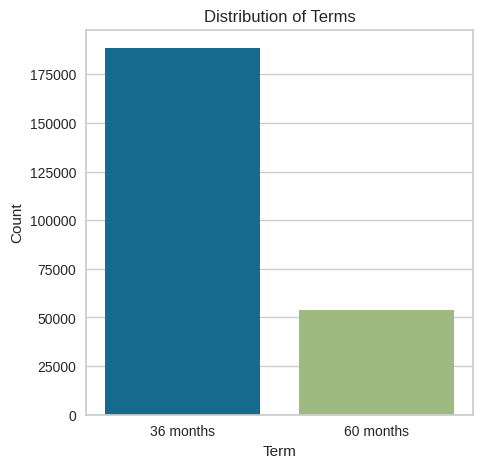

In [ ]:
plt.figure(figsize=(5,5))
sns.countplot(data=df, x='term', hue='term')
plt.title('Distribution of Terms')
plt.xlabel('Term')
plt.ylabel('Count')
plt.show()



*   Borrowers overwhelmingly favor 36-month terms (77.85%) over 60-month terms (22.15%).
*   Shorter terms may be seen as less risky by lenders, possibly due to quicker repayment.



In [ ]:
grade = df.groupby('grade').agg({'id': 'count'}).reset_index()
grade.columns=['grade', 'total']
grade.sort_values(by='total', ascending=False, inplace=True)
grade.set_index('grade', inplace=True)
grade['percentage'] = round((grade['total'] * 100) / sum(grade['total']), 2)
grade

,total,percentage
grade,,
B,72920,30.12
C,61942,25.59
A,39676,16.39
D,39428,16.29
E,18528,7.65
F,7532,3.11
G,2033,0.84


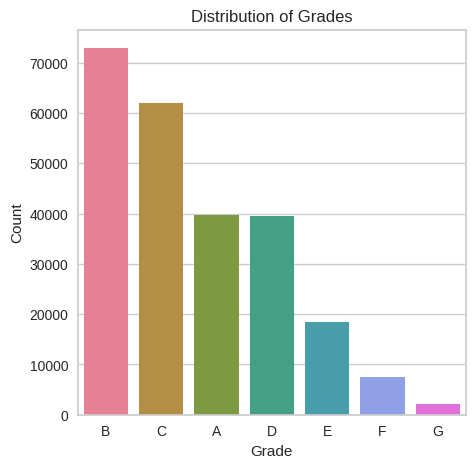

In [ ]:
plt.figure(figsize=(5,5))
sns.barplot(data=grade, x='grade', y='total', hue='grade')
plt.title('Distribution of Grades')
plt.xlabel('Grade')
plt.ylabel('Count')
plt.show()



*   Grades B and C dominate, comprising over half (55.71%) of loans.
*   Grades A, B, and C represent about 72% of loans, suggesting a moderate risk profile.
*   Grades D-G make up around 28% of loans, indicating fewer high-risk borrowers.



In [ ]:
sub_grade = df.groupby('sub_grade').agg({'id': 'count'}).reset_index()
sub_grade.columns=['sub_grade', 'total']
sub_grade.sort_values(by='total', ascending=False, inplace=True)
sub_grade.set_index('sub_grade', inplace=True)
sub_grade['percentage'] = round((sub_grade['total'] * 100) / sum(sub_grade['total']), 2)
sub_grade

,total,percentage
sub_grade,,
B3,17528,7.24
B4,16283,6.73
C1,14162,5.85
B2,14063,5.81
B5,13562,5.60
C2,13538,5.59
C3,12125,5.01
B1,11484,4.74
C4,11433,4.72


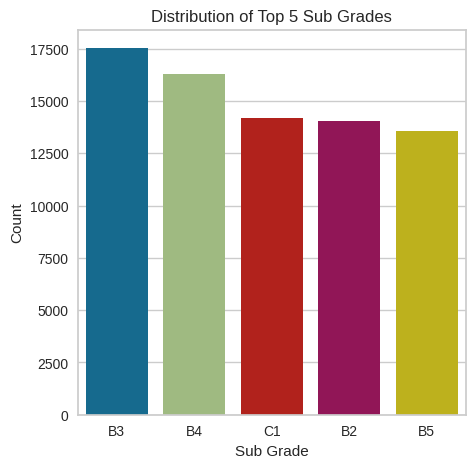

In [ ]:
# Filter top 5 subgrades
top_5_subgrades = sub_grade.head(5)

# Plotting the bar plot for top 5 subgrades
plt.figure(figsize=(5, 5))
sns.barplot(data=top_5_subgrades, x='sub_grade', y='total', hue='sub_grade')
plt.title('Distribution of Top 5 Sub Grades')
plt.xlabel('Sub Grade')
plt.ylabel('Count')
plt.show()



*   The top 5 sub-grades are all within grade B, comprising about 30.23% of loans.
*   Different sub-grades within grade B suggest varying creditworthiness levels.
*   Lenders should consider nuances within grade B when assessing risk and making lending decisions.



In [ ]:
emp_length = df.groupby('emp_length').agg({'id': 'count'}).reset_index()
emp_length.columns=['emp_length', 'total']
emp_length.sort_values(by='total', ascending=False, inplace=True)
emp_length.set_index('emp_length', inplace=True)
emp_length['percentage'] = round((emp_length['total'] * 100) / sum(emp_length['total']), 2)
emp_length

,total,percentage
emp_length,,
10+ years,81622,33.72
2 years,22642,9.35
< 1 year,20234,8.36
3 years,19680,8.13
5 years,17497,7.23
1 year,16280,6.73
4 years,15563,6.43
6 years,14496,5.99
7 years,13652,5.64


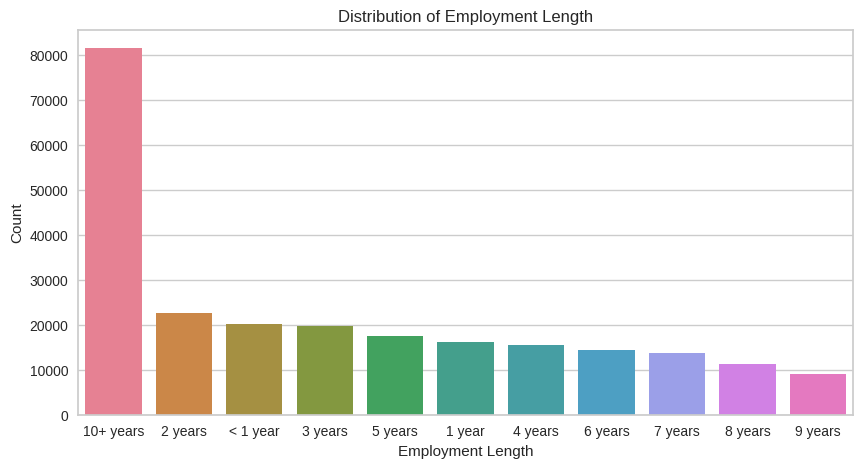

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(data=emp_length, x='emp_length', y='total', hue='emp_length')
plt.title('Distribution of Employment Length')
plt.xlabel('Employment Length')
plt.ylabel('Count')
plt.show()



*   Majority of borrowers (33.72%) have over 10 years of employment.
*   Longer employment lengths suggest borrower stability.
*   Borrowers with shorter employment lengths may pose higher risk.
*   Lenders should consider employment length in assessing borrower stability and risk.



In [ ]:
home_ownership = df.groupby('home_ownership').agg({'id': 'count'}).reset_index()
home_ownership.columns=['home_ownership', 'total']
home_ownership.sort_values(by='total', ascending=False, inplace=True)
home_ownership.set_index('home_ownership', inplace=True)
home_ownership['percentage'] = round((home_ownership['total'] * 100) / sum(home_ownership['total']), 2)
home_ownership

,total,percentage
home_ownership,,
MORTGAGE,118837,49.09
RENT,102562,42.37
OWN,20432,8.44
OTHER,179,0.07
NONE,48,0.02
ANY,1,0.00


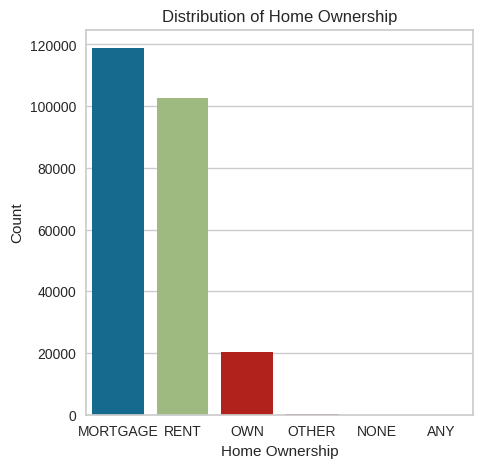

In [ ]:
plt.figure(figsize=(5,5))
sns.barplot(data=home_ownership, x='home_ownership', y='total', hue='home_ownership')
plt.title('Distribution of Home Ownership')
plt.xlabel('Home Ownership')
plt.ylabel('Count')
plt.show()



*   Majority of borrowers (91.9%) either have a mortgage (49.09%) or rent (42.37%) their homes.
*   Mortgage holders indicate stable housing, while renters comprise a significant portion, suggesting a trend or barriers to homeownership.



In [ ]:
verification_status = df.groupby('verification_status').agg({'id': 'count'}).reset_index()
verification_status.columns=['verification_status', 'total']
verification_status.sort_values(by='total', ascending=False, inplace=True)
verification_status.set_index('verification_status', inplace=True)
verification_status['percentage'] = round((verification_status['total'] * 100) / sum(verification_status['total']), 2)
verification_status

,total,percentage
verification_status,,
Verified,90030,37.19
Not Verified,83792,34.62
Source Verified,68237,28.19


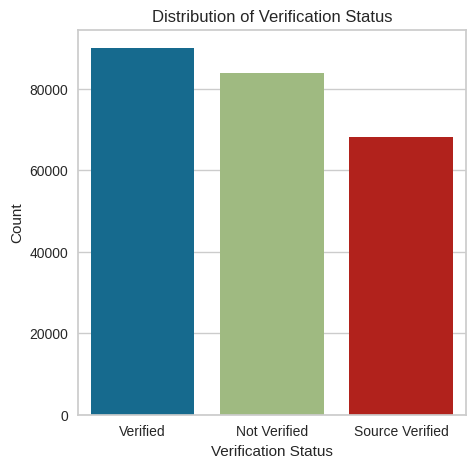

In [ ]:
plt.figure(figsize=(5,5))
sns.barplot(data=verification_status, x='verification_status', y='total', hue='verification_status')
plt.title('Distribution of Verification Status')
plt.xlabel('Verification Status')
plt.ylabel('Count')
plt.show()



*   Borrowers are divided into Verified (37.19%), Not Verified (34.62%), and Source Verified (28.19%).
*   Majority of borrowers (65.38%) undergo some form of verification, indicating trustworthiness. Verified borrowers may be perceived as lower risk.
*   Verification is crucial in the lending process for assessing borrower credibility and managing risk.



In [ ]:
loan_status = df.groupby('loan_status').agg({'id': 'count'}).reset_index()
loan_status.columns=['loan_status', 'total']
loan_status.sort_values(by='total', ascending=False, inplace=True)
loan_status.set_index('loan_status', inplace=True)
loan_status['percentage'] = round((loan_status['total'] * 100) / sum(loan_status['total']), 2)
loan_status

,total,percentage
loan_status,,
Fully Paid,184739,76.32
Charged Off,42475,17.55
Late (31-120 days),6900,2.85
In Grace Period,3146,1.30
Does not meet the credit policy. Status:Fully Paid,1988,0.82
Late (16-30 days),1218,0.50
Default,832,0.34
Does not meet the credit policy. Status:Charged Off,761,0.31


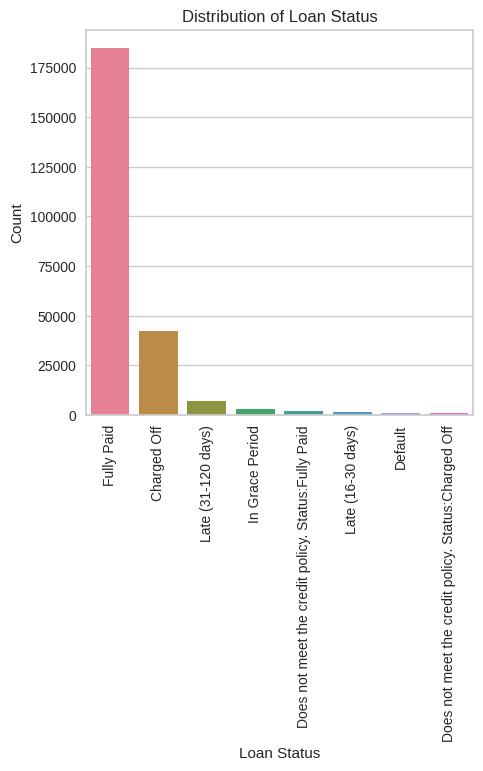

In [ ]:
plt.figure(figsize=(5,5))
sns.barplot(data=loan_status, x='loan_status', y='total', hue='loan_status')
plt.title('Distribution of Loan Status')
plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()



*   Most loans are fully paid (76.32%), followed by charged off loans (17.55%).
*   Charged off and default loans indicate higher risk, while fully paid loans reflect successful repayment.
*   Lenders need to closely watch late payments and non-compliant loans to manage risk and ensure policy compliance.



In [ ]:
pymnt_plan = df.replace({'pymnt_plan': {'y': 'Yes', 'n': 'No'}}).groupby('pymnt_plan').agg({'id': 'count'}).reset_index()
pymnt_plan.columns=['pymnt_plan', 'total']
pymnt_plan.sort_values(by='total', ascending=False, inplace=True)
pymnt_plan.set_index('pymnt_plan', inplace=True)
pymnt_plan['percentage'] = round((pymnt_plan['total'] * 100) / sum(pymnt_plan['total']), 2)
pymnt_plan

,total,percentage
pymnt_plan,,
No,242052,100.0
Yes,7,0.0


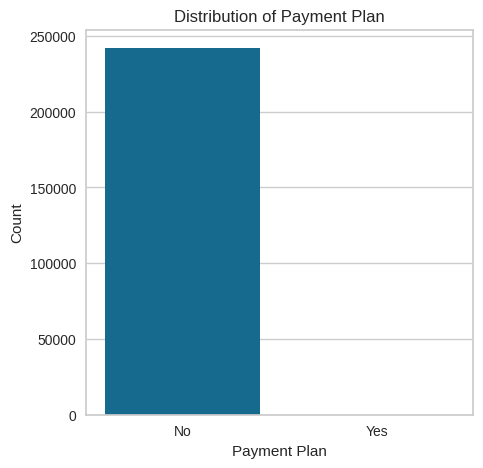

In [ ]:
plt.figure(figsize=(5,5))
sns.barplot(data=pymnt_plan, x='pymnt_plan', y='total', hue='pymnt_plan')
plt.title('Distribution of Payment Plan')
plt.xlabel('Payment Plan')
plt.ylabel('Count')
plt.show()



*   Nearly all loans (100%) don't have a payment plan, with only a tiny fraction (0.0%) opting for one.
*   Borrowers generally don't utilize payment plans, preferring standard repayment terms.
*   The rarity of payment plans suggests they have little impact on overall loan dynamics.



In [ ]:
purpose = df.groupby('purpose').agg({'id': 'count'}).reset_index()
purpose.columns=['purpose', 'total']
purpose.sort_values(by='total', ascending=False, inplace=True)
purpose.set_index('purpose', inplace=True)
purpose['percentage'] = round((purpose['total'] * 100) / sum(purpose['total']), 2)
purpose

,total,percentage
purpose,,
debt_consolidation,141061,58.28
credit_card,48265,19.94
home_improvement,14084,5.82
other,13847,5.72
major_purchase,6038,2.49
small_business,4843,2.00
car,3521,1.45
medical,2746,1.13
wedding,2020,0.83


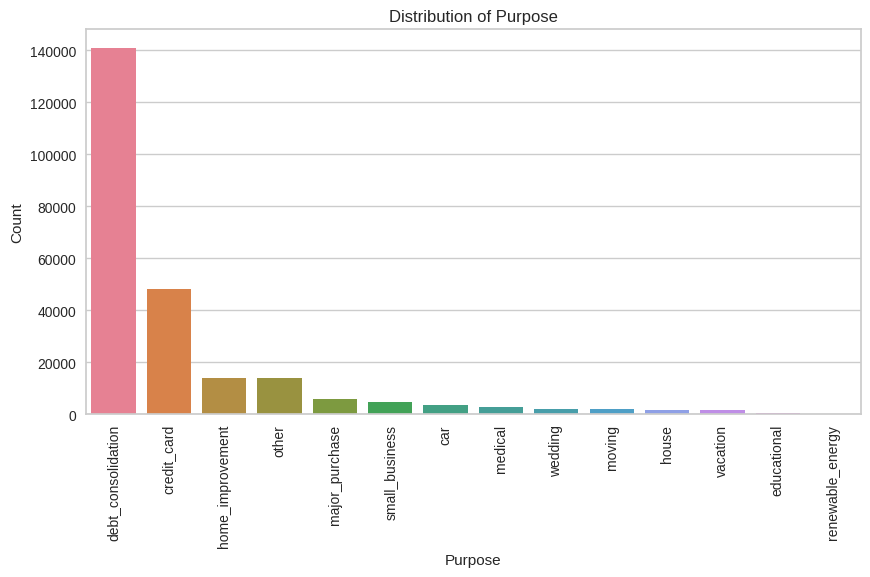

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(data=purpose, x='purpose', y='total', hue='purpose')
plt.title('Distribution of Purpose')
plt.xlabel('Purpose')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()



*   Majority of loans are for debt consolidation (58.28%) and credit card payments (19.94%).
*   Other significant purposes include home improvement (5.82%) and major purchases (2.49%).
*   Loans for small businesses, cars, medical expenses, weddings, and moving are less common, each comprising less than 2.5% of the total.
*   Loans for educational expenses, renewable energy, vacations, and housing are rare, each representing less than 1% of the total.
*   The prevalence of debt consolidation and credit card payments suggests that borrowers commonly use loans to manage existing debts or make large purchases.



In [ ]:
initial_list_status = df.replace({'initial_list_status': {'w': 'Whole', 'f': 'Fraction'}}).groupby('initial_list_status').agg({'id': 'count'}).reset_index()
initial_list_status.columns=['initial_list_status', 'total']
initial_list_status.sort_values(by='total', ascending=False, inplace=True)
initial_list_status.set_index('initial_list_status', inplace=True)
initial_list_status['percentage'] = round((initial_list_status['total'] * 100) / sum(initial_list_status['total']), 2)
initial_list_status

,total,percentage
initial_list_status,,
Fraction,179561,74.18
Whole,62498,25.82


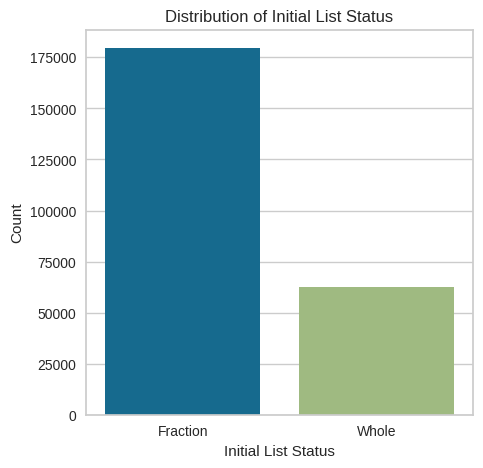

In [ ]:
plt.figure(figsize=(5,5))
sns.barplot(data=initial_list_status, x='initial_list_status', y='total', hue='initial_list_status')
plt.title('Distribution of Initial List Status')
plt.xlabel('Initial List Status')
plt.ylabel('Count')
plt.show()



*   Majority of loans (74.18%) are listed with fractional ownership, while 25.82% are listed as whole loans.
*   Fractional listings are more common, suggesting investor interest in diversification through partial loan investments.



In [21]:
target = df.replace({'target': {0: 'Bad Loan', 1: 'Good Loan'}}).groupby('target').agg({'id': 'count'}).reset_index()
target.columns=['target', 'total']
target.sort_values(by='total', ascending=False, inplace=True)
target.set_index('target', inplace=True)
target['percentage'] = round((target['total'] * 100) / sum(target['total']), 2)
target

,total,percentage
target,,
Good Loan,186727,77.14
Bad Loan,55332,22.86


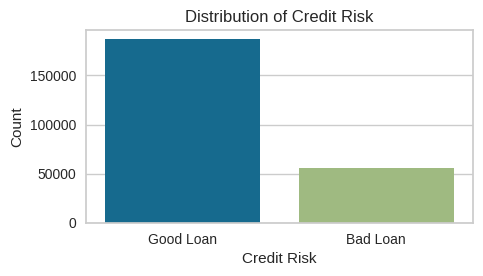

In [23]:
plt.figure(figsize=(5,2.5))
sns.barplot(data=target, x='target', y='total', hue='target')
plt.title('Distribution of Credit Risk')
plt.xlabel('Credit Risk')
plt.ylabel('Count')
plt.show()

### Numerical Features

In [ ]:
non_used = ['id', 'member_id', 'target']
uni_dist = df.select_dtypes(include=[np.float64,np.int64])
uni_dist = uni_dist[uni_dist.columns[~uni_dist.columns.isin(non_used)]]

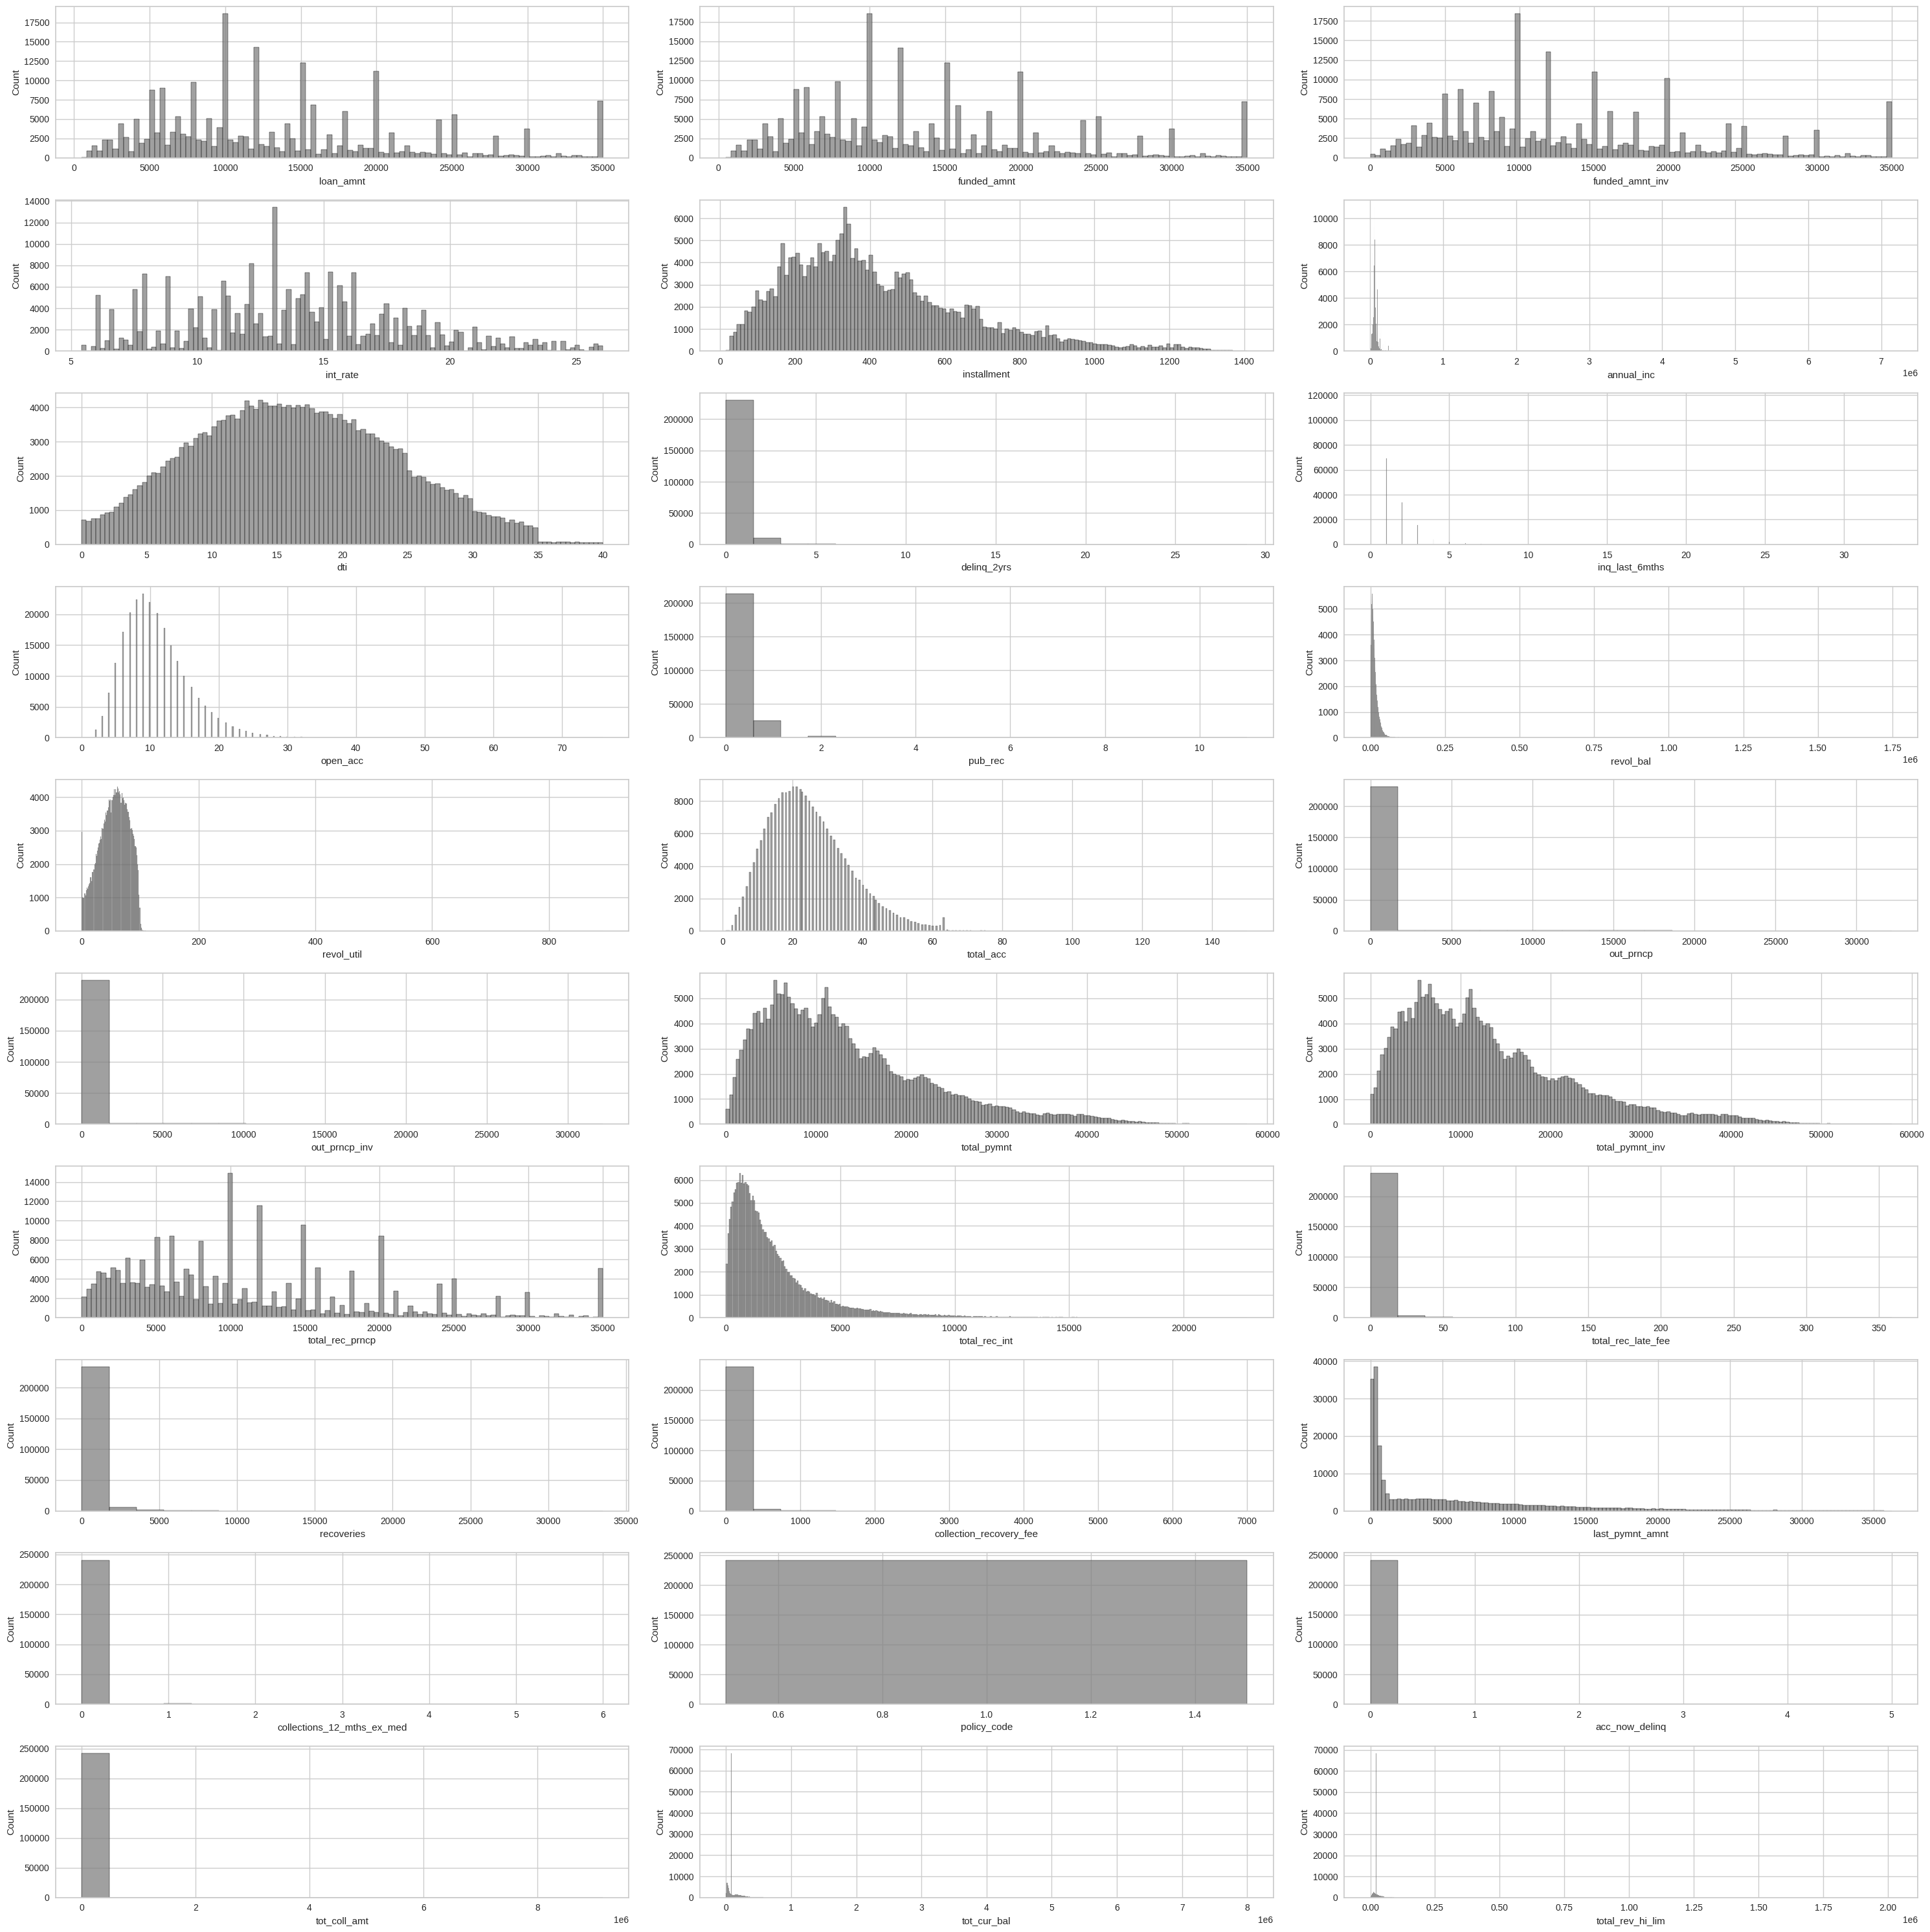

In [ ]:
plt.figure(figsize=(30, 30))
for col in range(len(uni_dist.columns)):
    plt.subplot(10, 3, col+1)
    sns.histplot(x=uni_dist.iloc[:, col], color='grey')
    plt.xlabel(uni_dist.columns[col])
plt.tight_layout()
plt.show()

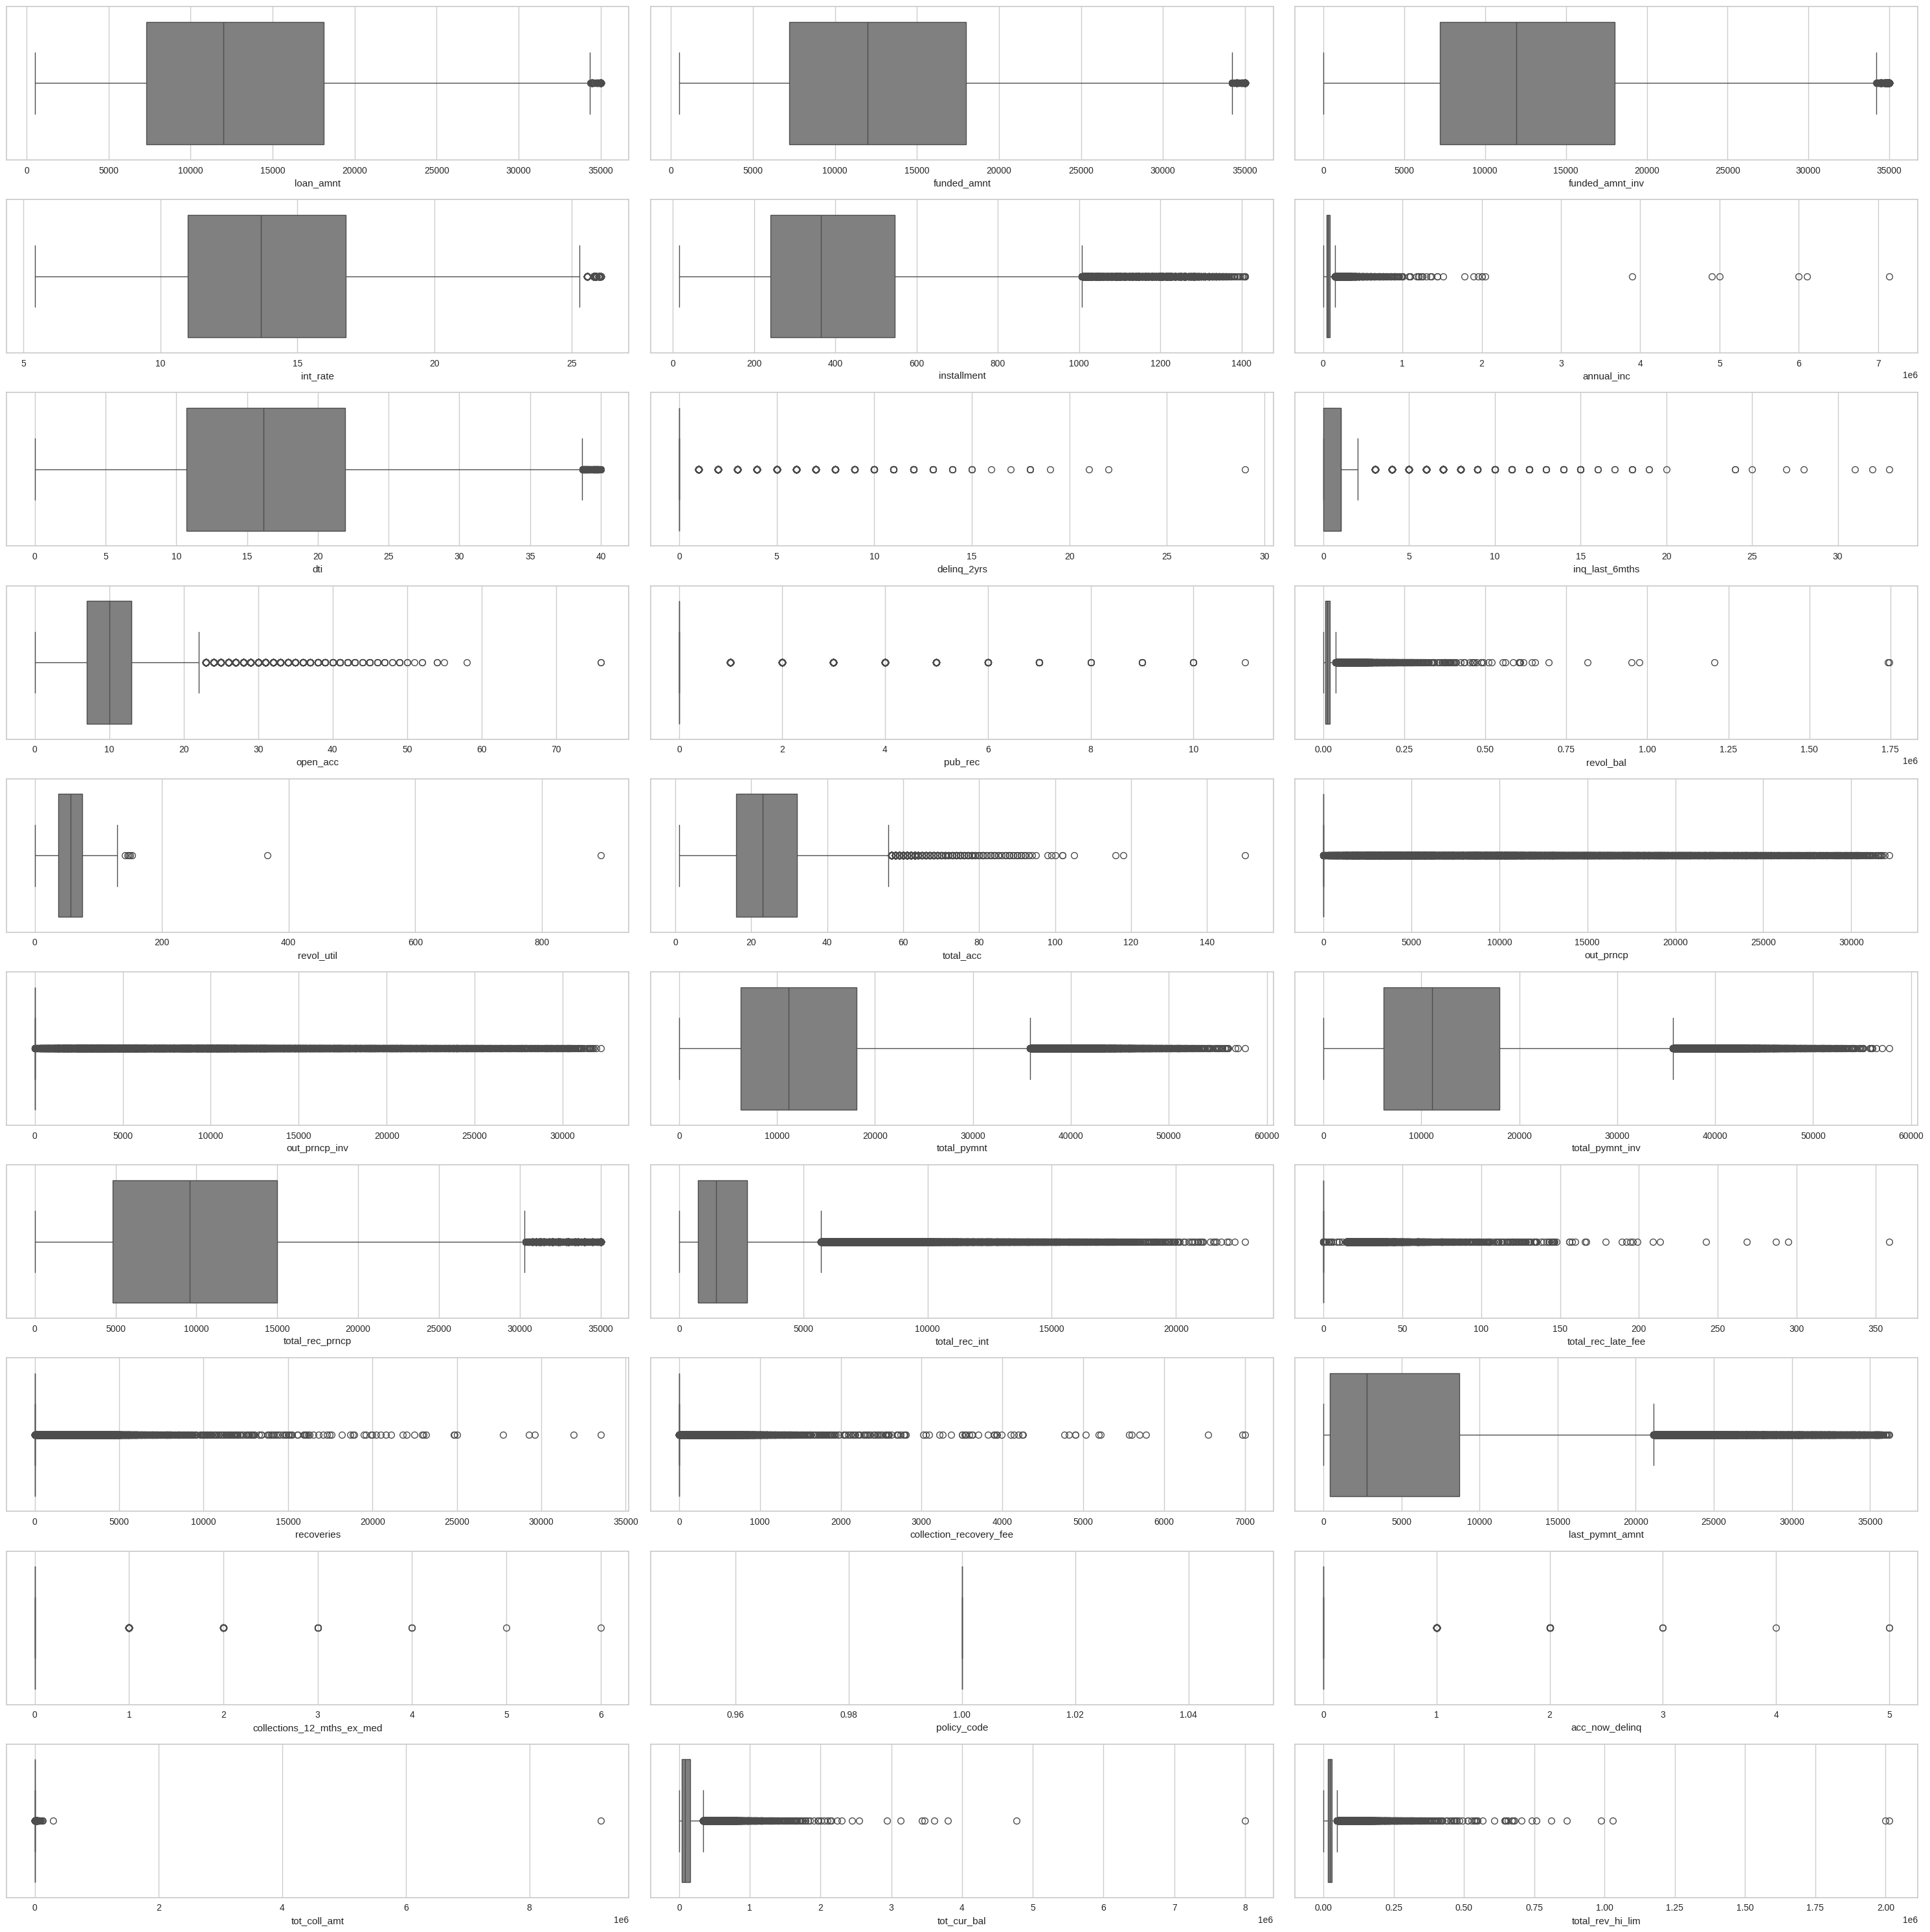

In [ ]:
plt.figure(figsize=(30, 30))
for col in range(len(uni_dist.columns)):
    plt.subplot(10, 3, col+1)
    sns.boxplot(x=uni_dist.iloc[:, col], color='grey')
    plt.xlabel(uni_dist.columns[col])
plt.tight_layout()
plt.show()

## Bivariate Analysis

In [3]:
loan_purpose = df.groupby(['purpose', 'target']).size().reset_index(name='total')
loan_purpose = loan_purpose.pivot(index='purpose', columns='target', values='total').fillna(0)
loan_purpose['total'] = loan_purpose.sum(axis=1)
loan_purpose.sort_values(by='total', ascending=False, inplace=True)
loan_purpose = loan_purpose.drop('total', axis=1)

In [4]:
target_dict = {'debt_consolidation': 'DEBT CONSOLIDATION',
               'credit_card': 'CREDIT CARD',
               'home_improvement': 'HOME IMPROVEMENT',
               'other': 'OTHER',
               'major_purchase': 'MAJOR PURCHASE',
               'small_business': 'SMALL BUSINESS',
               'car': 'CAR',
               'medical': 'MEDICAL',
               'wedding': 'WEDDING',
               'moving': 'MOVING',
               'house': 'HOUSE',
               'vacation': 'VACATION',
               'educational': 'EDUCATIONAL',
               'renewable_energy': 'RENEWABLE ENERGY'}
loan_purpose.rename(index=target_dict, inplace=True)

In [5]:
target_dict = {0: 'Bad Loan',
               1: 'Good Loan'}
loan_purpose.rename(columns=target_dict, inplace=True)
loan_purpose = loan_purpose[['Good Loan', 'Bad Loan']]
loan_purpose

target,Good Loan,Bad Loan
purpose,,
DEBT CONSOLIDATION,107249,33812
CREDIT CARD,38440,9825
HOME IMPROVEMENT,11219,2865
OTHER,10366,3481
MAJOR PURCHASE,5012,1026
SMALL BUSINESS,3253,1590
CAR,3017,504
MEDICAL,2090,656
WEDDING,1732,288


<Figure size 1000x1000 with 0 Axes>

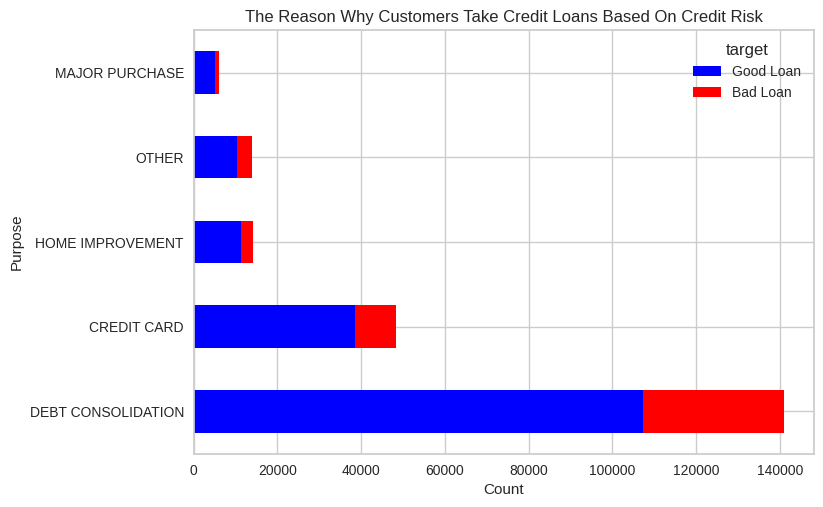

In [6]:
top_5_loan_purpose = loan_purpose.head()

plt.figure(figsize=(10, 10))
top_5_loan_purpose.plot(kind='barh', stacked=True, color=['blue', 'red'])
plt.xlabel("Count")
plt.ylabel("Purpose")
plt.title("The Reason Why Customers Take Credit Loans Based On Credit Risk")
plt.show()

In [7]:
loan_term = df.groupby(['term', 'target']).size().reset_index(name='total')
loan_term = loan_term.pivot(index='term', columns='target', values='total').fillna(0)
loan_term['total'] = loan_term.sum(axis=1)
loan_term.sort_values(by='total', ascending=False, inplace=True)
loan_term = loan_term.drop('total', axis=1)

In [8]:
target_dict = {0: 'Bad Loan',
               1: 'Good Loan'}
loan_term.rename(columns=target_dict, inplace=True)
loan_term = loan_term[['Good Loan', 'Bad Loan']]
loan_term

target,Good Loan,Bad Loan
term,,
36 months,152890,35558
60 months,33837,19774


<Figure size 1000x1000 with 0 Axes>

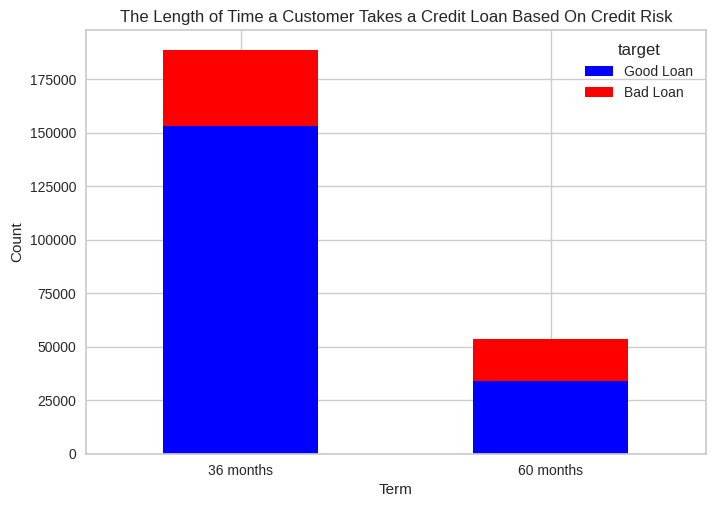

In [10]:
plt.figure(figsize=(10, 10))
loan_term.plot(kind='bar', stacked=True, color=['blue', 'red'])
plt.title("The Length of Time a Customer Takes a Credit Loan Based On Credit Risk")
plt.xlabel("Term")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

## Multivariate Analysis

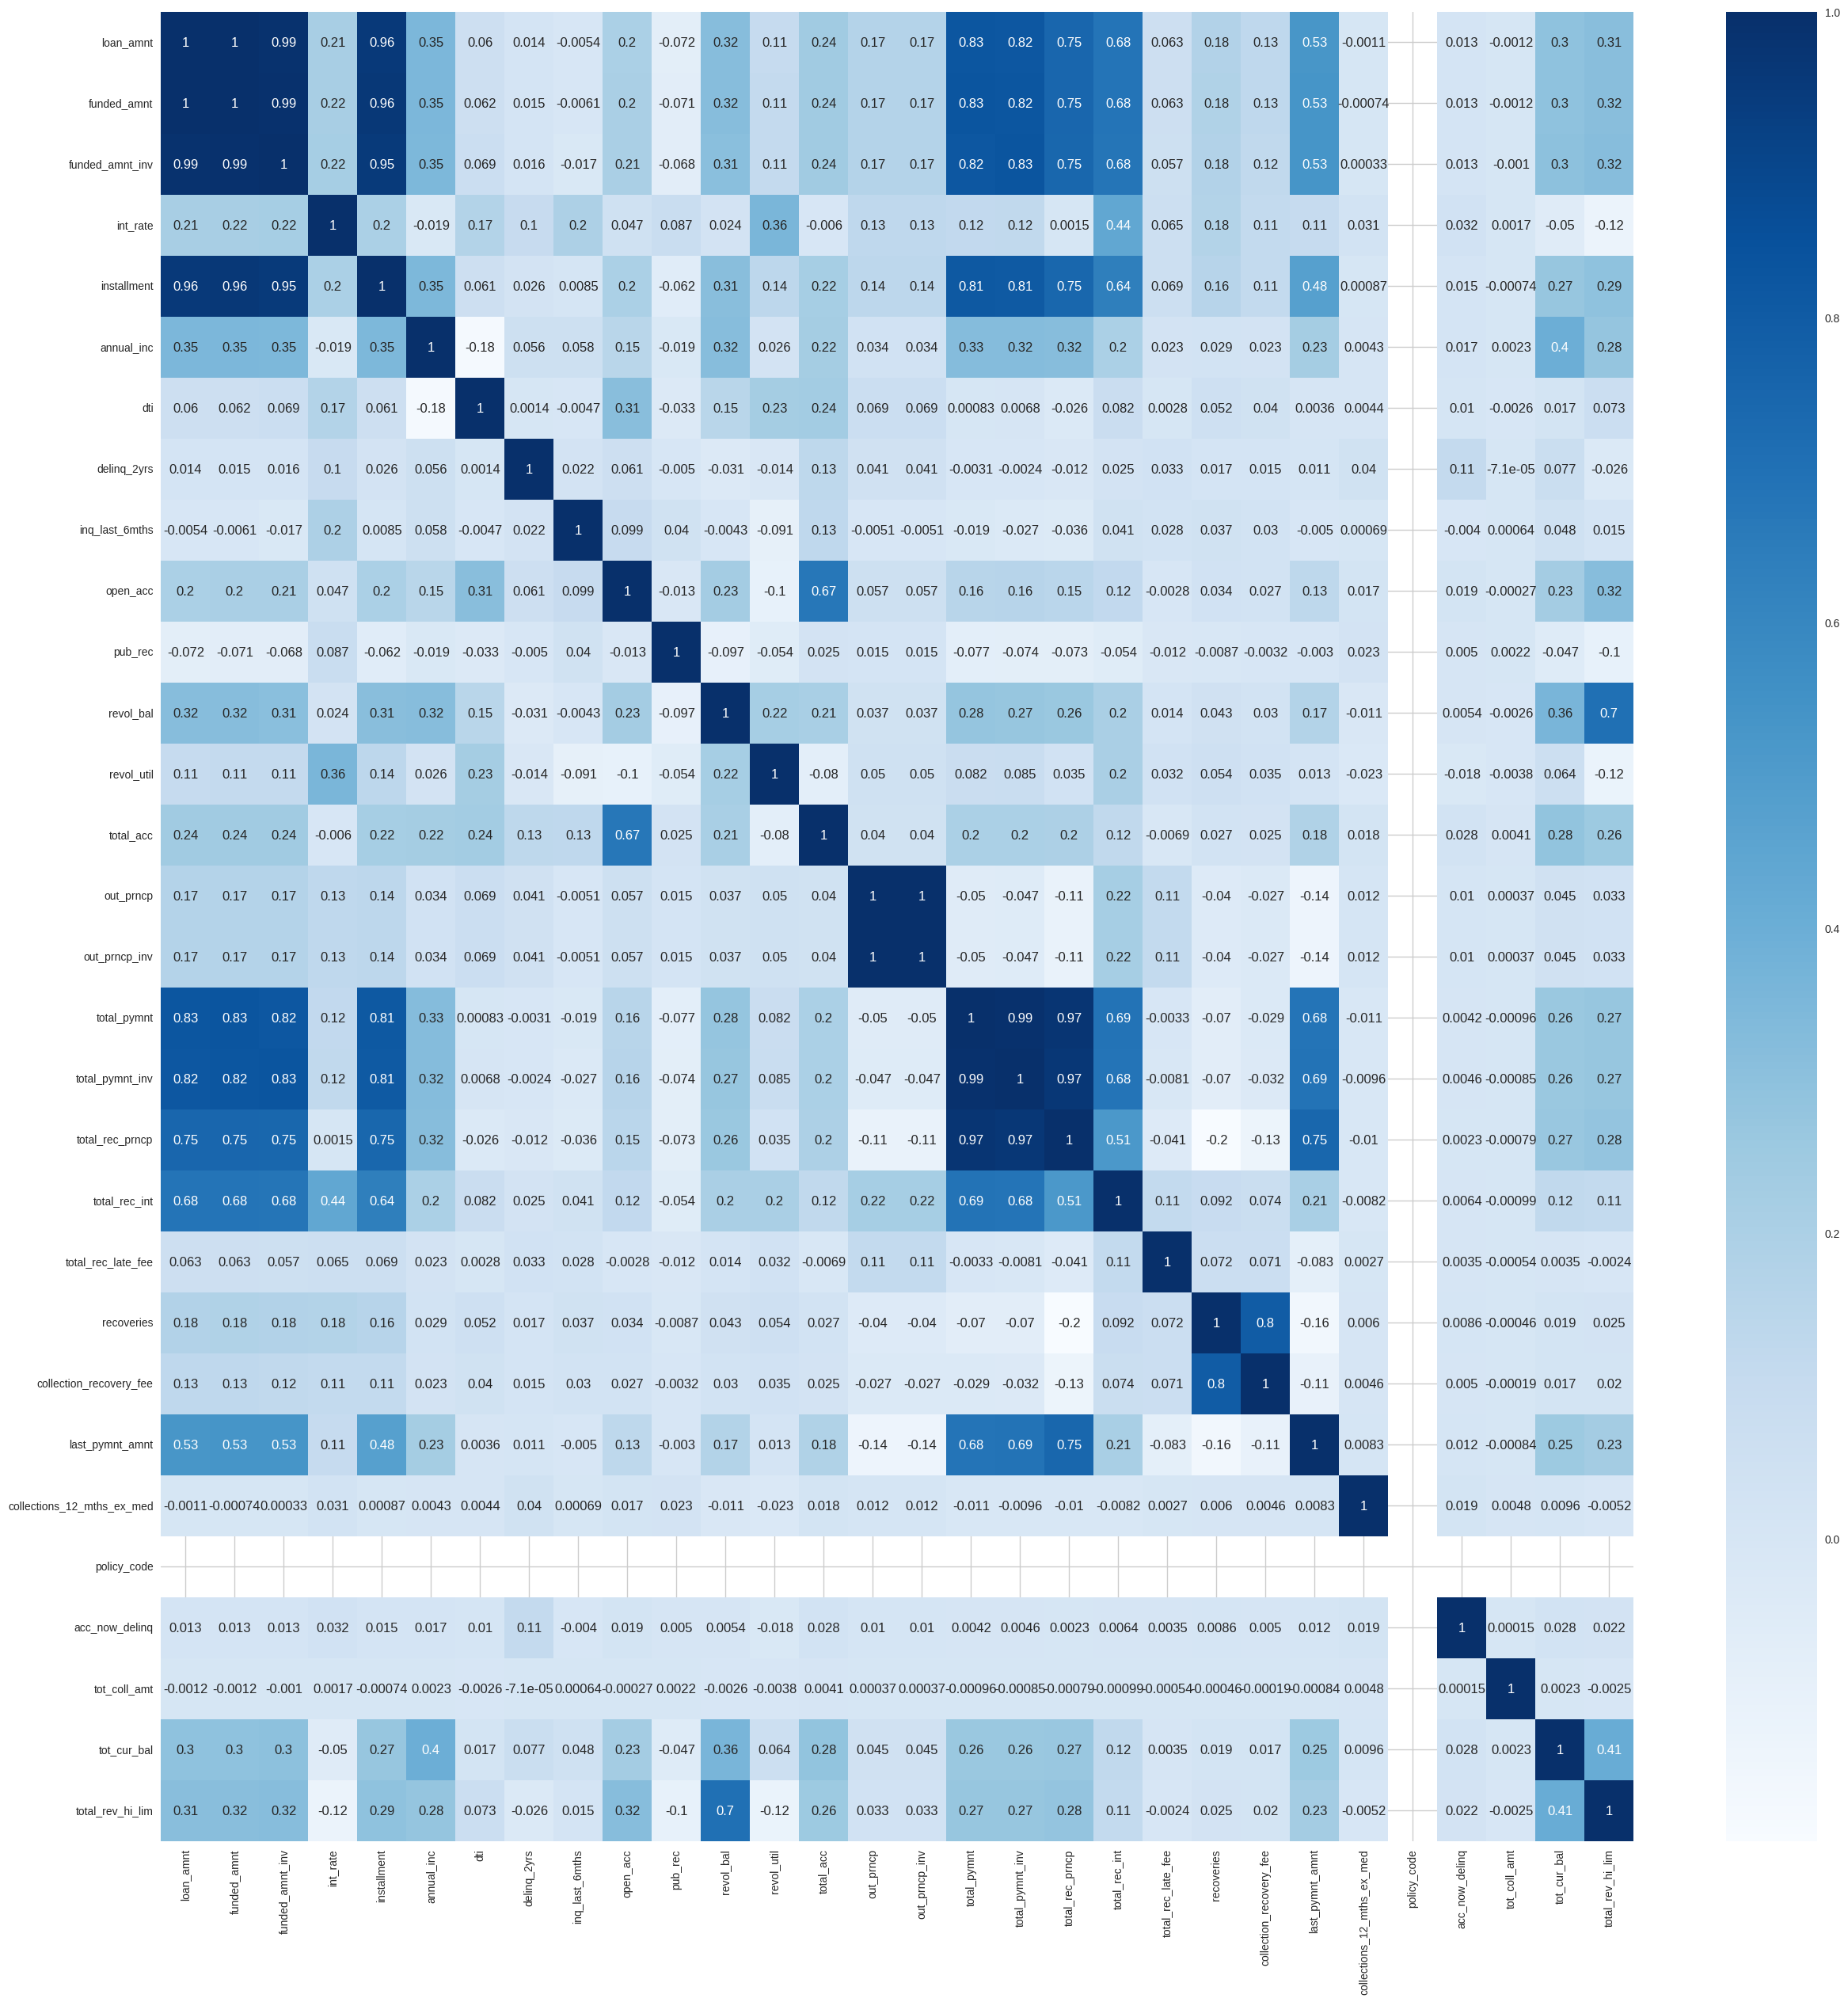

In [ ]:
fig = plt.figure(figsize=(30, 30))
sns.heatmap(uni_dist.corr(), cmap='Blues', annot=True);

# Data Preprocessing

## Feature Selection

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Datasets/cleaned_loan_data_2007_2014.csv")
print("Load cleaned data succeed!")

Load cleaned data succeed!


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242059 entries, 0 to 242058
Data columns (total 47 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id                          242059 non-null  int64  
 1   member_id                   242059 non-null  int64  
 2   loan_amnt                   242059 non-null  int64  
 3   funded_amnt                 242059 non-null  int64  
 4   funded_amnt_inv             242059 non-null  float64
 5   term                        242059 non-null  object 
 6   int_rate                    242059 non-null  float64
 7   installment                 242059 non-null  float64
 8   grade                       242059 non-null  object 
 9   sub_grade                   242059 non-null  object 
 10  emp_length                  242059 non-null  object 
 11  home_ownership              242059 non-null  object 
 12  annual_inc                  242059 non-null  float64
 13  verification_s

In [ ]:
unused_col = ['id', 'member_id', 'issue_d', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d', 'policy_code']
multi_col = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'sub_grade', 'loan_status', 'revol_bal', 'total_acc',
             'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
             'recoveries']
removed_col = unused_col + multi_col

In [ ]:
df_selected = df[df.columns[~df.columns.isin(removed_col)]].reset_index(drop=True)
df_selected.head()

,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_util,initial_list_status,total_rec_late_fee,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,target
0,36 months,10.65,162.87,B,10+ years,RENT,24000.0,Verified,n,credit_card,27.65,0.0,1.0,3.0,0.0,83.7,f,0.00,0.00,171.62,0.0,0.0,0.0,81539.0,22800.0,1
1,60 months,15.27,59.83,C,< 1 year,RENT,30000.0,Source Verified,n,car,1.00,0.0,5.0,3.0,0.0,9.4,f,0.00,1.11,119.66,0.0,0.0,0.0,81539.0,22800.0,0
2,36 months,15.96,84.33,C,10+ years,RENT,12252.0,Not Verified,n,small_business,8.72,0.0,2.0,2.0,0.0,98.5,f,0.00,0.00,649.91,0.0,0.0,0.0,81539.0,22800.0,1
3,36 months,13.49,339.31,C,10+ years,RENT,49200.0,Source Verified,n,other,20.00,0.0,1.0,10.0,0.0,21.0,f,16.97,0.00,357.48,0.0,0.0,0.0,81539.0,22800.0,1
4,36 months,7.90,156.46,A,3 years,RENT,36000.0,Source Verified,n,wedding,11.20,0.0,3.0,9.0,0.0,28.3,f,0.00,0.00,161.03,0.0,0.0,0.0,81539.0,22800.0,1


In [ ]:
df_selected.to_csv('selected_loan_data_2007_2014.csv', index=False)
!cp 'selected_loan_data_2007_2014.csv' '/content/drive/MyDrive/Datasets'
print("Saving selected data succeed!")

Saving selected data succeed!


## Feature Encoding

In [ ]:
df_loan = pd.read_csv('/content/drive/MyDrive/Datasets/selected_loan_data_2007_2014.csv')
print("Load selected data succeed!")
df_loan.head()

Load selected data succeed!


,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_util,initial_list_status,total_rec_late_fee,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,target
0,36 months,10.65,162.87,B,10+ years,RENT,24000.0,Verified,n,credit_card,27.65,0.0,1.0,3.0,0.0,83.7,f,0.00,0.00,171.62,0.0,0.0,0.0,81539.0,22800.0,1
1,60 months,15.27,59.83,C,< 1 year,RENT,30000.0,Source Verified,n,car,1.00,0.0,5.0,3.0,0.0,9.4,f,0.00,1.11,119.66,0.0,0.0,0.0,81539.0,22800.0,0
2,36 months,15.96,84.33,C,10+ years,RENT,12252.0,Not Verified,n,small_business,8.72,0.0,2.0,2.0,0.0,98.5,f,0.00,0.00,649.91,0.0,0.0,0.0,81539.0,22800.0,1
3,36 months,13.49,339.31,C,10+ years,RENT,49200.0,Source Verified,n,other,20.00,0.0,1.0,10.0,0.0,21.0,f,16.97,0.00,357.48,0.0,0.0,0.0,81539.0,22800.0,1
4,36 months,7.90,156.46,A,3 years,RENT,36000.0,Source Verified,n,wedding,11.20,0.0,3.0,9.0,0.0,28.3,f,0.00,0.00,161.03,0.0,0.0,0.0,81539.0,22800.0,1


In [ ]:
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242059 entries, 0 to 242058
Data columns (total 26 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   term                        242059 non-null  object 
 1   int_rate                    242059 non-null  float64
 2   installment                 242059 non-null  float64
 3   grade                       242059 non-null  object 
 4   emp_length                  242059 non-null  object 
 5   home_ownership              242059 non-null  object 
 6   annual_inc                  242059 non-null  float64
 7   verification_status         242059 non-null  object 
 8   pymnt_plan                  242059 non-null  object 
 9   purpose                     242059 non-null  object 
 10  dti                         242059 non-null  float64
 11  delinq_2yrs                 242059 non-null  float64
 12  inq_last_6mths              242059 non-null  float64
 13  open_acc      

In [ ]:
df_loan['term'].unique()

array(['36 months', '60 months'], dtype=object)

In [ ]:
df_loan['term'] = df_loan['term'].apply(lambda x: [int(text) for text in x.split() if text.isdigit()][0])
df_loan.head()

,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_util,initial_list_status,total_rec_late_fee,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,target
0,36,10.65,162.87,B,10+ years,RENT,24000.0,Verified,n,credit_card,27.65,0.0,1.0,3.0,0.0,83.7,f,0.00,0.00,171.62,0.0,0.0,0.0,81539.0,22800.0,1
1,60,15.27,59.83,C,< 1 year,RENT,30000.0,Source Verified,n,car,1.00,0.0,5.0,3.0,0.0,9.4,f,0.00,1.11,119.66,0.0,0.0,0.0,81539.0,22800.0,0
2,36,15.96,84.33,C,10+ years,RENT,12252.0,Not Verified,n,small_business,8.72,0.0,2.0,2.0,0.0,98.5,f,0.00,0.00,649.91,0.0,0.0,0.0,81539.0,22800.0,1
3,36,13.49,339.31,C,10+ years,RENT,49200.0,Source Verified,n,other,20.00,0.0,1.0,10.0,0.0,21.0,f,16.97,0.00,357.48,0.0,0.0,0.0,81539.0,22800.0,1
4,36,7.90,156.46,A,3 years,RENT,36000.0,Source Verified,n,wedding,11.20,0.0,3.0,9.0,0.0,28.3,f,0.00,0.00,161.03,0.0,0.0,0.0,81539.0,22800.0,1


In [ ]:
df_loan['grade'].unique()

array(['B', 'C', 'A', 'E', 'F', 'D', 'G'], dtype=object)

In [ ]:
target_dict = {'A': 6,
               'B': 5,
               'C': 4,
               'D': 3,
               'E': 2,
               'F': 1,
               'G': 0}
df_loan["grade"] = df_loan["grade"].map(target_dict)

In [ ]:
df_loan.head()

,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_util,initial_list_status,total_rec_late_fee,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,target
0,36,10.65,162.87,5,10+ years,RENT,24000.0,Verified,n,credit_card,27.65,0.0,1.0,3.0,0.0,83.7,f,0.00,0.00,171.62,0.0,0.0,0.0,81539.0,22800.0,1
1,60,15.27,59.83,4,< 1 year,RENT,30000.0,Source Verified,n,car,1.00,0.0,5.0,3.0,0.0,9.4,f,0.00,1.11,119.66,0.0,0.0,0.0,81539.0,22800.0,0
2,36,15.96,84.33,4,10+ years,RENT,12252.0,Not Verified,n,small_business,8.72,0.0,2.0,2.0,0.0,98.5,f,0.00,0.00,649.91,0.0,0.0,0.0,81539.0,22800.0,1
3,36,13.49,339.31,4,10+ years,RENT,49200.0,Source Verified,n,other,20.00,0.0,1.0,10.0,0.0,21.0,f,16.97,0.00,357.48,0.0,0.0,0.0,81539.0,22800.0,1
4,36,7.90,156.46,6,3 years,RENT,36000.0,Source Verified,n,wedding,11.20,0.0,3.0,9.0,0.0,28.3,f,0.00,0.00,161.03,0.0,0.0,0.0,81539.0,22800.0,1


In [ ]:
df_loan['emp_length'].unique()

array(['10+ years', '< 1 year', '3 years', '9 years', '4 years',
       '5 years', '1 year', '6 years', '2 years', '7 years', '8 years'],
      dtype=object)

In [ ]:
target_dict = {'< 1 year': 0,
               '1 year': 1,
               '2 years': 2,
               '3 years': 3,
               '4 years': 4,
               '5 years': 5,
               '6 years': 6,
               '7 years': 7,
               '8 years': 8,
               '9 years': 9,
               '10+ years': 10}
df_loan["emp_length"] = df_loan["emp_length"].map(target_dict)

In [ ]:
df_loan.head()

,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_util,initial_list_status,total_rec_late_fee,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,target
0,36,10.65,162.87,5,10,RENT,24000.0,Verified,n,credit_card,27.65,0.0,1.0,3.0,0.0,83.7,f,0.00,0.00,171.62,0.0,0.0,0.0,81539.0,22800.0,1
1,60,15.27,59.83,4,0,RENT,30000.0,Source Verified,n,car,1.00,0.0,5.0,3.0,0.0,9.4,f,0.00,1.11,119.66,0.0,0.0,0.0,81539.0,22800.0,0
2,36,15.96,84.33,4,10,RENT,12252.0,Not Verified,n,small_business,8.72,0.0,2.0,2.0,0.0,98.5,f,0.00,0.00,649.91,0.0,0.0,0.0,81539.0,22800.0,1
3,36,13.49,339.31,4,10,RENT,49200.0,Source Verified,n,other,20.00,0.0,1.0,10.0,0.0,21.0,f,16.97,0.00,357.48,0.0,0.0,0.0,81539.0,22800.0,1
4,36,7.90,156.46,6,3,RENT,36000.0,Source Verified,n,wedding,11.20,0.0,3.0,9.0,0.0,28.3,f,0.00,0.00,161.03,0.0,0.0,0.0,81539.0,22800.0,1


In [ ]:
df_loan['home_ownership'].unique()

array(['RENT', 'OWN', 'MORTGAGE', 'OTHER', 'NONE', 'ANY'], dtype=object)

In [ ]:
df_loan['home_ownership'].value_counts()

MORTGAGE    118837
RENT        102562
OWN          20432
OTHER          179
NONE            48
ANY              1
Name: home_ownership, dtype: int64



*   `ANY`, `NONE` will be aggregated into `OTHER`



In [ ]:
target_dict = {'MORTGAGE': 'MORTGAGE',
               'RENT': 'RENT',
               'OWN': 'OWN',
               'OTHER': 'OTHER',
               'ANY': 'OTHER',
               'NONE': 'OTHER'}
df_loan["home_ownership"] = df_loan["home_ownership"].map(target_dict)

In [ ]:
df_loan.head()

,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_util,initial_list_status,total_rec_late_fee,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,target
0,36,10.65,162.87,5,10,RENT,24000.0,Verified,n,credit_card,27.65,0.0,1.0,3.0,0.0,83.7,f,0.00,0.00,171.62,0.0,0.0,0.0,81539.0,22800.0,1
1,60,15.27,59.83,4,0,RENT,30000.0,Source Verified,n,car,1.00,0.0,5.0,3.0,0.0,9.4,f,0.00,1.11,119.66,0.0,0.0,0.0,81539.0,22800.0,0
2,36,15.96,84.33,4,10,RENT,12252.0,Not Verified,n,small_business,8.72,0.0,2.0,2.0,0.0,98.5,f,0.00,0.00,649.91,0.0,0.0,0.0,81539.0,22800.0,1
3,36,13.49,339.31,4,10,RENT,49200.0,Source Verified,n,other,20.00,0.0,1.0,10.0,0.0,21.0,f,16.97,0.00,357.48,0.0,0.0,0.0,81539.0,22800.0,1
4,36,7.90,156.46,6,3,RENT,36000.0,Source Verified,n,wedding,11.20,0.0,3.0,9.0,0.0,28.3,f,0.00,0.00,161.03,0.0,0.0,0.0,81539.0,22800.0,1


In [ ]:
encoder = OneHotEncoder(sparse=False)
home_ownership_enc = pd.DataFrame(encoder.fit_transform(df_loan[['home_ownership']]))
home_ownership_enc.columns = encoder.get_feature_names_out(['home_ownership'])
df_loan = pd.concat([df_loan, home_ownership_enc], axis=1)
df_loan.drop(["home_ownership"], axis=1, inplace=True)
df_loan.head()

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,term,int_rate,installment,grade,emp_length,annual_inc,verification_status,pymnt_plan,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_util,initial_list_status,total_rec_late_fee,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,target,home_ownership_MORTGAGE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT
0,36,10.65,162.87,5,10,24000.0,Verified,n,credit_card,27.65,0.0,1.0,3.0,0.0,83.7,f,0.00,0.00,171.62,0.0,0.0,0.0,81539.0,22800.0,1,0.0,0.0,0.0,1.0
1,60,15.27,59.83,4,0,30000.0,Source Verified,n,car,1.00,0.0,5.0,3.0,0.0,9.4,f,0.00,1.11,119.66,0.0,0.0,0.0,81539.0,22800.0,0,0.0,0.0,0.0,1.0
2,36,15.96,84.33,4,10,12252.0,Not Verified,n,small_business,8.72,0.0,2.0,2.0,0.0,98.5,f,0.00,0.00,649.91,0.0,0.0,0.0,81539.0,22800.0,1,0.0,0.0,0.0,1.0
3,36,13.49,339.31,4,10,49200.0,Source Verified,n,other,20.00,0.0,1.0,10.0,0.0,21.0,f,16.97,0.00,357.48,0.0,0.0,0.0,81539.0,22800.0,1,0.0,0.0,0.0,1.0
4,36,7.90,156.46,6,3,36000.0,Source Verified,n,wedding,11.20,0.0,3.0,9.0,0.0,28.3,f,0.00,0.00,161.03,0.0,0.0,0.0,81539.0,22800.0,1,0.0,0.0,0.0,1.0


In [ ]:
df_loan['verification_status'].unique()

array(['Verified', 'Source Verified', 'Not Verified'], dtype=object)

In [ ]:
df_loan['verification_status'].value_counts()

Verified           90030
Not Verified       83792
Source Verified    68237
Name: verification_status, dtype: int64

In [ ]:
target_dict = {'Verified': 'VERIFIED',
               'Not Verified': 'NOT VERIFIED',
               'Source Verified': 'SOURCE VERIFIED'}
df_loan['verification_status'] = df_loan['verification_status'].map(target_dict)

In [ ]:
verification_status_enc = pd.DataFrame(encoder.fit_transform(df_loan[['verification_status']]))
verification_status_enc.columns = encoder.get_feature_names_out(['verification_status'])
df_loan = pd.concat([df_loan, verification_status_enc], axis=1)
df_loan.drop(["verification_status"], axis=1, inplace=True)
df_loan.head()

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,term,int_rate,installment,grade,emp_length,annual_inc,pymnt_plan,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_util,initial_list_status,total_rec_late_fee,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,target,home_ownership_MORTGAGE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_NOT VERIFIED,verification_status_SOURCE VERIFIED,verification_status_VERIFIED
0,36,10.65,162.87,5,10,24000.0,n,credit_card,27.65,0.0,1.0,3.0,0.0,83.7,f,0.00,0.00,171.62,0.0,0.0,0.0,81539.0,22800.0,1,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,60,15.27,59.83,4,0,30000.0,n,car,1.00,0.0,5.0,3.0,0.0,9.4,f,0.00,1.11,119.66,0.0,0.0,0.0,81539.0,22800.0,0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,36,15.96,84.33,4,10,12252.0,n,small_business,8.72,0.0,2.0,2.0,0.0,98.5,f,0.00,0.00,649.91,0.0,0.0,0.0,81539.0,22800.0,1,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,36,13.49,339.31,4,10,49200.0,n,other,20.00,0.0,1.0,10.0,0.0,21.0,f,16.97,0.00,357.48,0.0,0.0,0.0,81539.0,22800.0,1,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,36,7.90,156.46,6,3,36000.0,n,wedding,11.20,0.0,3.0,9.0,0.0,28.3,f,0.00,0.00,161.03,0.0,0.0,0.0,81539.0,22800.0,1,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [ ]:
df_loan['pymnt_plan'].unique()

array(['n', 'y'], dtype=object)

In [ ]:
target_dict = {'n': 0,
               'y': 1}
df_loan['pymnt_plan'] = df_loan['pymnt_plan'].map(target_dict)

In [ ]:
df_loan.head()

,term,int_rate,installment,grade,emp_length,annual_inc,pymnt_plan,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_util,initial_list_status,total_rec_late_fee,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,target,home_ownership_MORTGAGE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_NOT VERIFIED,verification_status_SOURCE VERIFIED,verification_status_VERIFIED
0,36,10.65,162.87,5,10,24000.0,0,credit_card,27.65,0.0,1.0,3.0,0.0,83.7,f,0.00,0.00,171.62,0.0,0.0,0.0,81539.0,22800.0,1,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,60,15.27,59.83,4,0,30000.0,0,car,1.00,0.0,5.0,3.0,0.0,9.4,f,0.00,1.11,119.66,0.0,0.0,0.0,81539.0,22800.0,0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,36,15.96,84.33,4,10,12252.0,0,small_business,8.72,0.0,2.0,2.0,0.0,98.5,f,0.00,0.00,649.91,0.0,0.0,0.0,81539.0,22800.0,1,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,36,13.49,339.31,4,10,49200.0,0,other,20.00,0.0,1.0,10.0,0.0,21.0,f,16.97,0.00,357.48,0.0,0.0,0.0,81539.0,22800.0,1,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,36,7.90,156.46,6,3,36000.0,0,wedding,11.20,0.0,3.0,9.0,0.0,28.3,f,0.00,0.00,161.03,0.0,0.0,0.0,81539.0,22800.0,1,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [ ]:
df_loan['purpose'].unique()

array(['credit_card', 'car', 'small_business', 'other', 'wedding',
       'debt_consolidation', 'home_improvement', 'major_purchase',
       'medical', 'moving', 'vacation', 'house', 'renewable_energy',
       'educational'], dtype=object)

In [ ]:
df_loan['purpose'].value_counts()

debt_consolidation    141061
credit_card            48265
home_improvement       14084
other                  13847
major_purchase          6038
small_business          4843
car                     3521
medical                 2746
wedding                 2020
moving                  1915
house                   1555
vacation                1483
educational              422
renewable_energy         259
Name: purpose, dtype: int64

In [ ]:
target_dict = {'debt_consolidation': 'DEBT CONSOLIDATION',
               'credit_card': 'CREDIT CARD',
               'home_improvement': 'HOME IMPROVEMENT',
               'other': 'OTHER',
               'major_purchase': 'MAJOR PURCHASE',
               'small_business': 'SMALL BUSINESS',
               'car': 'CAR',
               'medical': 'MEDICAL',
               'wedding': 'WEDDING',
               'moving': 'MOVING',
               'house': 'HOUSE',
               'vacation': 'VACATION',
               'educational': 'EDUCATIONAL',
               'renewable_energy': 'RENEWABLE ENERGY'}
df_loan['purpose'] = df_loan['purpose'].map(target_dict)

In [ ]:
df_loan['purpose'].value_counts()

DEBT CONSOLIDATION    141061
CREDIT CARD            48265
HOME IMPROVEMENT       14084
OTHER                  13847
MAJOR PURCHASE          6038
SMALL BUSINESS          4843
CAR                     3521
MEDICAL                 2746
WEDDING                 2020
MOVING                  1915
HOUSE                   1555
VACATION                1483
EDUCATIONAL              422
RENEWABLE ENERGY         259
Name: purpose, dtype: int64



*   `HOME IMPROVEMENT`, `CAR`, `MEDICAL`, `WEDDING`, `MOVING`, `HOUSE`, `VACATION`, `EDUCATIONAL` will be aggregated into `PRIVATE USE`
*   `RENEWABLE ENERGY` will be aggregated into `OTHER`



In [ ]:
target_dict = {'DEBT CONSOLIDATION': 'DEBT CONSOLIDATION',
               'CREDIT CARD': 'CREDIT CARD',
               'HOME IMPROVEMENT': 'PRIVATE USE',
               'OTHER': 'OTHER',
               'MAJOR PURCHASE': 'MAJOR PURCHASE',
               'SMALL BUSINESS': 'SMALL BUSINESS',
               'CAR': 'PRIVATE USE',
               'MEDICAL': 'PRIVATE USE',
               'WEDDING': 'PRIVATE USE',
               'MOVING': 'PRIVATE USE',
               'HOUSE': 'PRIVATE USE',
               'VACATION': 'PRIVATE USE',
               'EDUCATIONAL': 'PRIVATE USE',
               'RENEWABLE ENERGY': 'OTHER'}
df_loan['purpose'] = df_loan['purpose'].map(target_dict)

In [ ]:
df_loan['purpose'].value_counts()

DEBT CONSOLIDATION    141061
CREDIT CARD            48265
PRIVATE USE            27746
OTHER                  14106
MAJOR PURCHASE          6038
SMALL BUSINESS          4843
Name: purpose, dtype: int64

In [ ]:
purpose_enc = pd.DataFrame(encoder.fit_transform(df_loan[['purpose']]))
purpose_enc.columns = encoder.get_feature_names_out(['purpose'])
df_loan = pd.concat([df_loan, purpose_enc], axis=1)
df_loan.drop(["purpose"], axis=1, inplace=True)
df_loan.head()

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,term,int_rate,installment,grade,emp_length,annual_inc,pymnt_plan,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_util,initial_list_status,total_rec_late_fee,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,target,home_ownership_MORTGAGE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_NOT VERIFIED,verification_status_SOURCE VERIFIED,verification_status_VERIFIED,purpose_CREDIT CARD,purpose_DEBT CONSOLIDATION,purpose_MAJOR PURCHASE,purpose_OTHER,purpose_PRIVATE USE,purpose_SMALL BUSINESS
0,36,10.65,162.87,5,10,24000.0,0,27.65,0.0,1.0,3.0,0.0,83.7,f,0.00,0.00,171.62,0.0,0.0,0.0,81539.0,22800.0,1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,60,15.27,59.83,4,0,30000.0,0,1.00,0.0,5.0,3.0,0.0,9.4,f,0.00,1.11,119.66,0.0,0.0,0.0,81539.0,22800.0,0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,36,15.96,84.33,4,10,12252.0,0,8.72,0.0,2.0,2.0,0.0,98.5,f,0.00,0.00,649.91,0.0,0.0,0.0,81539.0,22800.0,1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,36,13.49,339.31,4,10,49200.0,0,20.00,0.0,1.0,10.0,0.0,21.0,f,16.97,0.00,357.48,0.0,0.0,0.0,81539.0,22800.0,1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,36,7.90,156.46,6,3,36000.0,0,11.20,0.0,3.0,9.0,0.0,28.3,f,0.00,0.00,161.03,0.0,0.0,0.0,81539.0,22800.0,1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
df_loan['initial_list_status'].unique()

array(['f', 'w'], dtype=object)

In [ ]:
target_dict = {'f': 'FRACTIONAL',
               'w': 'WHOLE'}
df_loan['initial_list_status'] = df_loan['initial_list_status'].map(target_dict)

In [ ]:
initial_list_status_enc = pd.DataFrame(encoder.fit_transform(df_loan[['initial_list_status']]))
initial_list_status_enc.columns = encoder.get_feature_names_out(['initial_list_status'])
df_loan = pd.concat([df_loan, initial_list_status_enc], axis=1)
df_loan.drop(["initial_list_status"], axis=1, inplace=True)
df_loan.head()

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,term,int_rate,installment,grade,emp_length,annual_inc,pymnt_plan,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_util,total_rec_late_fee,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,target,home_ownership_MORTGAGE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_NOT VERIFIED,verification_status_SOURCE VERIFIED,verification_status_VERIFIED,purpose_CREDIT CARD,purpose_DEBT CONSOLIDATION,purpose_MAJOR PURCHASE,purpose_OTHER,purpose_PRIVATE USE,purpose_SMALL BUSINESS,initial_list_status_FRACTIONAL,initial_list_status_WHOLE
0,36,10.65,162.87,5,10,24000.0,0,27.65,0.0,1.0,3.0,0.0,83.7,0.00,0.00,171.62,0.0,0.0,0.0,81539.0,22800.0,1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,60,15.27,59.83,4,0,30000.0,0,1.00,0.0,5.0,3.0,0.0,9.4,0.00,1.11,119.66,0.0,0.0,0.0,81539.0,22800.0,0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,36,15.96,84.33,4,10,12252.0,0,8.72,0.0,2.0,2.0,0.0,98.5,0.00,0.00,649.91,0.0,0.0,0.0,81539.0,22800.0,1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,36,13.49,339.31,4,10,49200.0,0,20.00,0.0,1.0,10.0,0.0,21.0,16.97,0.00,357.48,0.0,0.0,0.0,81539.0,22800.0,1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,36,7.90,156.46,6,3,36000.0,0,11.20,0.0,3.0,9.0,0.0,28.3,0.00,0.00,161.03,0.0,0.0,0.0,81539.0,22800.0,1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [ ]:
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242059 entries, 0 to 242058
Data columns (total 37 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   term                                 242059 non-null  int64  
 1   int_rate                             242059 non-null  float64
 2   installment                          242059 non-null  float64
 3   grade                                242059 non-null  int64  
 4   emp_length                           242059 non-null  int64  
 5   annual_inc                           242059 non-null  float64
 6   pymnt_plan                           242059 non-null  int64  
 7   dti                                  242059 non-null  float64
 8   delinq_2yrs                          242059 non-null  float64
 9   inq_last_6mths                       242059 non-null  float64
 10  open_acc                             242059 non-null  float64
 11  pub_rec      

In [ ]:
df_loan.to_csv('enc_loan_data_2007_2014.csv', index=False)
!cp 'enc_loan_data_2007_2014.csv' '/content/drive/MyDrive/Datasets'
print("Saving encoding data succeed!")

Saving encoding data succeed!


## Handling Outliers

In [ ]:
df_loan.head()

,term,int_rate,installment,grade,emp_length,annual_inc,pymnt_plan,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_util,total_rec_late_fee,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,target,home_ownership_MORTGAGE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_NOT VERIFIED,verification_status_SOURCE VERIFIED,verification_status_VERIFIED,purpose_CREDIT CARD,purpose_DEBT CONSOLIDATION,purpose_MAJOR PURCHASE,purpose_OTHER,purpose_PRIVATE USE,purpose_SMALL BUSINESS,initial_list_status_FRACTIONAL,initial_list_status_WHOLE
0,36,10.65,162.87,5,10,24000.0,0,27.65,0.0,1.0,3.0,0.0,83.7,0.00,0.00,171.62,0.0,0.0,0.0,81539.0,22800.0,1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,60,15.27,59.83,4,0,30000.0,0,1.00,0.0,5.0,3.0,0.0,9.4,0.00,1.11,119.66,0.0,0.0,0.0,81539.0,22800.0,0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,36,15.96,84.33,4,10,12252.0,0,8.72,0.0,2.0,2.0,0.0,98.5,0.00,0.00,649.91,0.0,0.0,0.0,81539.0,22800.0,1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,36,13.49,339.31,4,10,49200.0,0,20.00,0.0,1.0,10.0,0.0,21.0,16.97,0.00,357.48,0.0,0.0,0.0,81539.0,22800.0,1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,36,7.90,156.46,6,3,36000.0,0,11.20,0.0,3.0,9.0,0.0,28.3,0.00,0.00,161.03,0.0,0.0,0.0,81539.0,22800.0,1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [ ]:
def remove_outliers_iqr(df, columns, threshold=1.5):
    """
    Remove outliers from a DataFrame using the Interquartile Range (IQR) method.

    Parameters:
        df (DataFrame): Input DataFrame.
        columns (list): List of columns to consider for outlier removal.
        threshold (int or float): Threshold value for outlier detection.
            Values beyond Q3 + threshold * IQR or below Q1 - threshold * IQR
            are considered outliers. Default is 1.5.

    Returns:
        DataFrame: DataFrame with outliers removed.
    """
    df_out = df.copy()
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR

        df_out = df_out[(df_out[col] >= lower_bound) & (df_out[col] <= upper_bound)]
    return df_out

In [ ]:
outlier_col = ['installment', 'annual_inc', 'open_acc', 'total_rec_late_fee', 'collection_recovery_fee',
               'last_pymnt_amnt', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim']

In [ ]:
print("dataframe shape before removing outliers: ", df_loan.shape)

for col in outlier_col:
    df_out = remove_outliers_iqr(df_loan, [col])

print("dataframe shape after removing outliers: ", df_out.shape)

dataframe shape before removing outliers:  (242059, 37)
dataframe shape after removing outliers:  (218675, 37)


In [ ]:
df_out.to_csv('out_loan_data_2007_2014.csv', index=False)
!cp 'out_loan_data_2007_2014.csv' '/content/drive/MyDrive/Datasets'
print("Saving non-outliers data succeed!")

Saving non-outliers data succeed!


# Modelling

In [2]:
df_loan = pd.read_csv('/content/drive/MyDrive/Datasets/out_loan_data_2007_2014.csv')
print("Load prepared data succeed!")

Load prepared data succeed!


In [3]:
df_loan.head()

,term,int_rate,installment,grade,emp_length,annual_inc,pymnt_plan,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_util,total_rec_late_fee,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,target,home_ownership_MORTGAGE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_NOT VERIFIED,verification_status_SOURCE VERIFIED,verification_status_VERIFIED,purpose_CREDIT CARD,purpose_DEBT CONSOLIDATION,purpose_MAJOR PURCHASE,purpose_OTHER,purpose_PRIVATE USE,purpose_SMALL BUSINESS,initial_list_status_FRACTIONAL,initial_list_status_WHOLE
0,36,10.65,162.87,5,10,24000.0,0,27.65,0.0,1.0,3.0,0.0,83.7,0.00,0.00,171.62,0.0,0.0,0.0,81539.0,22800.0,1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,60,15.27,59.83,4,0,30000.0,0,1.00,0.0,5.0,3.0,0.0,9.4,0.00,1.11,119.66,0.0,0.0,0.0,81539.0,22800.0,0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,36,15.96,84.33,4,10,12252.0,0,8.72,0.0,2.0,2.0,0.0,98.5,0.00,0.00,649.91,0.0,0.0,0.0,81539.0,22800.0,1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,36,13.49,339.31,4,10,49200.0,0,20.00,0.0,1.0,10.0,0.0,21.0,16.97,0.00,357.48,0.0,0.0,0.0,81539.0,22800.0,1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,36,7.90,156.46,6,3,36000.0,0,11.20,0.0,3.0,9.0,0.0,28.3,0.00,0.00,161.03,0.0,0.0,0.0,81539.0,22800.0,1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [4]:
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218675 entries, 0 to 218674
Data columns (total 37 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   term                                 218675 non-null  int64  
 1   int_rate                             218675 non-null  float64
 2   installment                          218675 non-null  float64
 3   grade                                218675 non-null  int64  
 4   emp_length                           218675 non-null  int64  
 5   annual_inc                           218675 non-null  float64
 6   pymnt_plan                           218675 non-null  int64  
 7   dti                                  218675 non-null  float64
 8   delinq_2yrs                          218675 non-null  float64
 9   inq_last_6mths                       218675 non-null  float64
 10  open_acc                             218675 non-null  float64
 11  pub_rec      

## Split Train Test Data

In [5]:
X = df_loan.loc[:, df_loan.columns != 'target']
y = df_loan['target']

In [6]:
def split_data(X, y, test_size=0.2, random_state=42):
    """
    Split the data into train, validation, and test sets.

    Parameters:
        X (array-like): The features.
        y (array-like): The target variable.
        test_size (float, optional): The proportion of the dataset to include in the test split. Defaults to 0.2.
        random_state (int, optional): Controls the shuffling applied to the data before applying the split. Defaults to 42.

    Returns:
        tuple: Four arrays: X_train, X_val, y_train, y_val
    """
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, shuffle=True, random_state=random_state)

    X_test = X_val.iloc[-1, :]
    y_test = y_val.iloc[-1]
    y_test = np.array(y_test).reshape(1)
    X_val = X_val.iloc[:-1, :]
    y_val = y_val.iloc[:-1]

    return X_train, X_val, y_train, y_val, X_test, y_test

In [7]:
X_train, X_val, y_train, y_val, X_test, y_test = split_data(X, y)
print("Splitting data succeed!")

Splitting data succeed!


In [8]:
from collections import Counter
print("number of classes from training data: ", Counter(y_train))
print("number of classes from validation data: ", Counter(y_val))

number of classes from training data:  Counter({1: 134399, 0: 40541})
number of classes from validation data:  Counter({1: 33516, 0: 10218})


## Find the Top 3 Best Algorithms using PyCaret

In [ ]:
train = pd.concat([X_train, y_train], axis=1)
validation = pd.concat([X_val, y_val], axis=1)

In [ ]:
# init setup
reg = setup(data=train, target='target')

,Description,Value
0,Session id,1682
1,Target,target
2,Target type,Binary
3,Original data shape,"(174940, 37)"
4,Transformed data shape,"(174940, 37)"
5,Transformed train set shape,"(122457, 37)"
6,Transformed test set shape,"(52483, 37)"
7,Numeric features,36
8,Preprocess,True
9,Imputation type,simple


In [ ]:
best_model = compare_models(sort='Accuracy')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.9574,0.9891,0.9782,0.9667,0.9724,0.8787,0.8790,2.1110
lightgbm,Light Gradient Boosting Machine,0.9551,0.9881,0.9744,0.9674,0.9709,0.8728,0.8730,5.3540
rf,Random Forest Classifier,0.9470,0.9844,0.9709,0.9606,0.9657,0.8493,0.8496,25.0700
gbc,Gradient Boosting Classifier,0.9422,0.9838,0.9664,0.9587,0.9625,0.8361,0.8363,36.5090
ada,Ada Boost Classifier,0.9335,0.9802,0.9646,0.9496,0.9571,0.8098,0.8103,7.4440
dt,Decision Tree Classifier,0.9310,0.9053,0.9533,0.9568,0.9550,0.8071,0.8072,2.2570
et,Extra Trees Classifier,0.9265,0.9734,0.9690,0.9374,0.9530,0.7852,0.7875,22.6240
lr,Logistic Regression,0.8995,0.9594,0.9521,0.9199,0.9357,0.7056,0.7080,12.9260
nb,Naive Bayes,0.8904,0.9526,0.9558,0.9076,0.9307,0.6681,0.6782,0.2120
lda,Linear Discriminant Analysis,0.8582,0.9184,0.9598,0.8692,0.9123,0.5471,0.5660,0.5330


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

## Transform Pipeline

In [9]:
def log_transform(x):
    return np.log(x+1)

In [10]:
# Pipeline to transform the numerical features
numerical = ['int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc',
             'revol_util', 'total_rec_late_fee', 'collection_recovery_fee', 'last_pymnt_amnt', 'tot_coll_amt',
             'tot_cur_bal', 'total_rev_hi_lim']
skewed = ['installment', 'annual_inc', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'revol_util',
          'total_rec_late_fee', 'collection_recovery_fee', 'last_pymnt_amnt', 'tot_coll_amt', 'tot_cur_bal',
          'total_rev_hi_lim']
diff = list(set(numerical) - set(skewed))

In [11]:
smt = SMOTE(random_state=42)
ss = StandardScaler()
log_transform = FunctionTransformer(log_transform)

numerical_transformer = Pipeline([
    ('log_transform', log_transform),
     ('scaler', ss)])

ct = ColumnTransformer([
    ('num_transform', numerical_transformer, skewed),
     ('scaler', ss, diff)], remainder='passthrough')

In [12]:
def evaluate_ks_and_roc_auc(y_real, y_proba):
    """
    Evaluate Kolmogorov-Smirnov (KS) statistic and ROC AUC.

    Parameters:
        y_real (array-like): Ground truth labels.
        y_proba (array-like): Predicted probabilities for the positive class.

    Returns:
        tuple: KS statistic and ROC AUC score.
    """
    # Unite both visions to be able to filter
    df = pd.DataFrame({'real': y_real, 'proba': y_proba[:, 1]})

    # Recover each class
    class0 = df[df['real'] == 0]
    class1 = df[df['real'] == 1]

    # Calculate KS statistic
    ks = ks_2samp(class0['proba'], class1['proba'])

    # Calculate ROC AUC score
    roc_auc = roc_auc_score(df['real'], df['proba'])

    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"KS: {ks.statistic:.4f} (p-value: {ks.pvalue:.3e})")

    return ks.statistic, roc_auc

In [13]:
def plot_confusion_matrix(cm,
                          target_names,
                          title="Confusion Matrix",
                          cmap=None,
                          normalize=True):
    """
    Plot a confusion matrix.

    Parameters:
        cm (array-like): Confusion matrix.
        target_names (list): Class names.
        title (str, optional): Title of the plot. Defaults to 'Confusion matrix'.
        cmap (matplotlib colormap, optional): The colormap to use. Defaults to None.
        normalize (bool, optional): If True, plot the proportions. If False, plot the raw numbers. Defaults to True.

    Returns:
        None
    """
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label\naccuracy={:0.4f}; misclass={:0.4f}".format(accuracy, misclass))
    plt.grid(False)
    plt.show()

## Extreme Gradient Boosting

ROC AUC: 0.9892
KS: 0.8835 (p-value: 0.000e+00)
Classification Report XGBoost Classifier: 
               precision    recall  f1-score   support

           0       0.92      0.90      0.91     10218
           1       0.97      0.98      0.97     33516

    accuracy                           0.96     43734
   macro avg       0.94      0.94      0.94     43734
weighted avg       0.96      0.96      0.96     43734



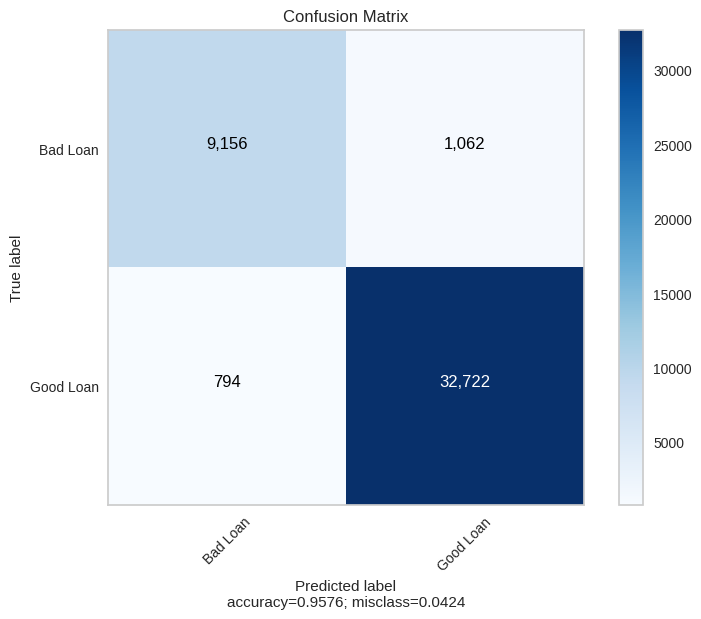

In [14]:
# Create an instance of XGBClassifier
xgb = XGBClassifier(random_state=42)

# Main pipeline for fitting.
xgb_model = Pipeline([
    ('col_transform', ct),
     ('smt', smt),
      ('xgb', xgb)])

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict_proba(X_val)
predicted = xgb_model.predict(X_val)

# Print AUC, KS Score, and Classification Report
ks, auc = evaluate_ks_and_roc_auc(y_val, y_pred_xgb)
matrix = classification_report(y_val, predicted)
print("Classification Report XGBoost Classifier: \n", matrix)
cm = confusion_matrix(y_val, predicted)
target_names = ['Bad Loan', 'Good Loan']
plot_confusion_matrix(cm, target_names, title='Confusion Matrix', cmap=None, normalize=False)

## Light Gradient Boosting Machine

[LightGBM] [Info] Number of positive: 134399, number of negative: 134399
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.089009 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8401
[LightGBM] [Info] Number of data points in the train set: 268798, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
ROC AUC: 0.9877
KS: 0.8778 (p-value: 0.000e+00)
Classification Report LightGBM Classifier: 
               precision    recall  f1-score   support

           0       0.90      0.90      0.90     10218
           1       0.97      0.97      0.97     33516

    accuracy                           0.95     43734
   macro avg       0.93      0.94      0.93     43734
weighted avg       0.95      0.95      0.95     43734



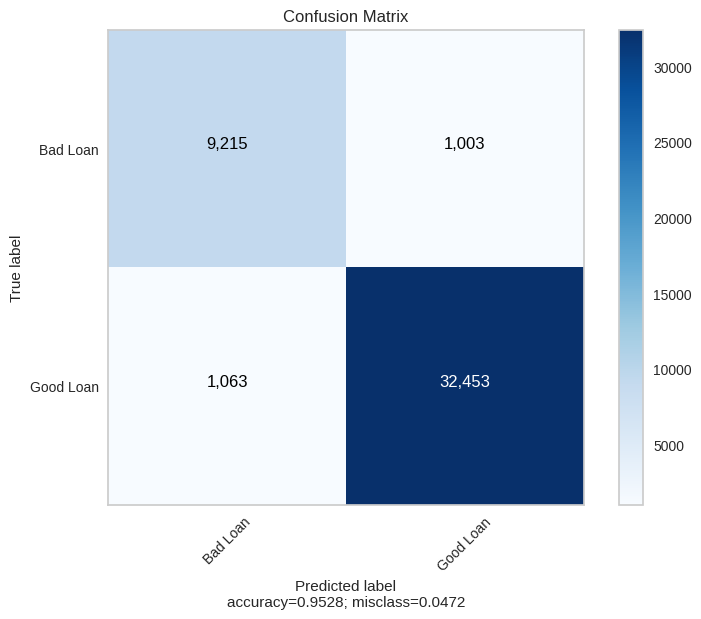

In [15]:
# Create an instance of LGBMClassifier
lgbm = LGBMClassifier(random_state=42)

# Main pipeline for fitting.
lgbm_model = Pipeline([
    ('col_transform', ct),
     ('smt', smt),
      ('lgbm', lgbm)])

lgbm_model.fit(X_train, y_train)
y_pred_lgbm = lgbm_model.predict_proba(X_val)
predicted = lgbm_model.predict(X_val)

# Print AUC, KS Score, and Classification Report
ks, auc = evaluate_ks_and_roc_auc(y_val, y_pred_lgbm)
matrix = classification_report(y_val, predicted)
print("Classification Report LightGBM Classifier: \n", matrix)
cm = confusion_matrix(y_val, predicted)
target_names = ['Bad Loan', 'Good Loan']
plot_confusion_matrix(cm, target_names, title='Confusion Matrix', cmap=None, normalize=False)

## Random Forest Classifier

ROC AUC: 0.9846
KS: 0.8735 (p-value: 0.000e+00)
Classification report Random Forest Classifier: 
               precision    recall  f1-score   support

           0       0.87      0.91      0.89     10218
           1       0.97      0.96      0.96     33516

    accuracy                           0.95     43734
   macro avg       0.92      0.93      0.93     43734
weighted avg       0.95      0.95      0.95     43734



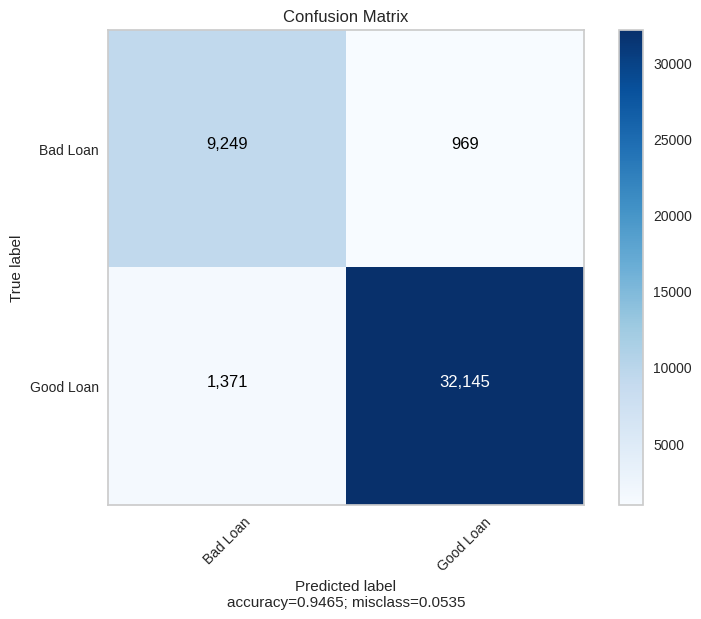

In [16]:
# Create an instance of RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Main pipeline for fitting.
rf_model = Pipeline([
    ('col_transform', ct),
     ('smt', smt),
      ('rf', rf)])

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict_proba(X_val)
predicted = rf_model.predict(X_val)

# Print AUC, KS Score, and Classification Report
ks, auc = evaluate_ks_and_roc_auc(y_val, y_pred_rf)
matrix = classification_report(y_val, predicted)
print("Classification report Random Forest Classifier: \n", matrix)
cm = confusion_matrix(y_val, predicted)
target_names = ['Bad Loan', 'Good Loan']
plot_confusion_matrix(cm, target_names, title='Confusion Matrix', cmap=None, normalize=False)

## Compare Model Performance

In [17]:
# Initialize lists to store evaluation results
models = ['XGBClassifier', 'LGBMClassifier', 'RandomForestClassifier']
metrics = ['FN', 'Recall', 'ROC-AUC', 'KS']
results = []

# Evaluate each model
for model, y_proba in zip(models, [y_pred_xgb, y_pred_lgbm, y_pred_rf]):
    y_pred = np.argmax(y_proba, axis=1)

    cm = confusion_matrix(y_val, y_pred)

    fn = cm[1, 0]
    recall = round(recall_score(y_val, y_pred), 4)
    auc = round(evaluate_ks_and_roc_auc(y_val, y_proba)[1], 4)
    ks = round(evaluate_ks_and_roc_auc(y_val, y_proba)[0], 4)

    results.append([fn, recall, auc, ks])

# Create a DataFrame to store the results
model_performance = pd.DataFrame(results, columns=metrics, index=models)

ROC AUC: 0.9892
KS: 0.8835 (p-value: 0.000e+00)
ROC AUC: 0.9892
KS: 0.8835 (p-value: 0.000e+00)
ROC AUC: 0.9877
KS: 0.8778 (p-value: 0.000e+00)
ROC AUC: 0.9877
KS: 0.8778 (p-value: 0.000e+00)
ROC AUC: 0.9846
KS: 0.8735 (p-value: 0.000e+00)
ROC AUC: 0.9846
KS: 0.8735 (p-value: 0.000e+00)


In [18]:
model_performance

,FN,Recall,ROC-AUC,KS
XGBClassifier,794,0.9763,0.9892,0.8835
LGBMClassifier,1063,0.9683,0.9877,0.8778
RandomForestClassifier,1371,0.9591,0.9846,0.8735


In [19]:
model_performance.to_csv('model_performance.csv', index=True)
!cp 'model_performance.csv' '/content/drive/MyDrive/Datasets'
print("Saving model performance data succeed!")

Saving model performance data succeed!


# Model Optimization & Evaluation

## Hyperparameter Tuning

ROC AUC: 0.9901
KS: 0.8931 (p-value: 0.000e+00)
Classification Report XGBoost Classifier: 
               precision    recall  f1-score   support

           0       0.92      0.90      0.91     10218
           1       0.97      0.98      0.97     33516

    accuracy                           0.96     43734
   macro avg       0.95      0.94      0.94     43734
weighted avg       0.96      0.96      0.96     43734



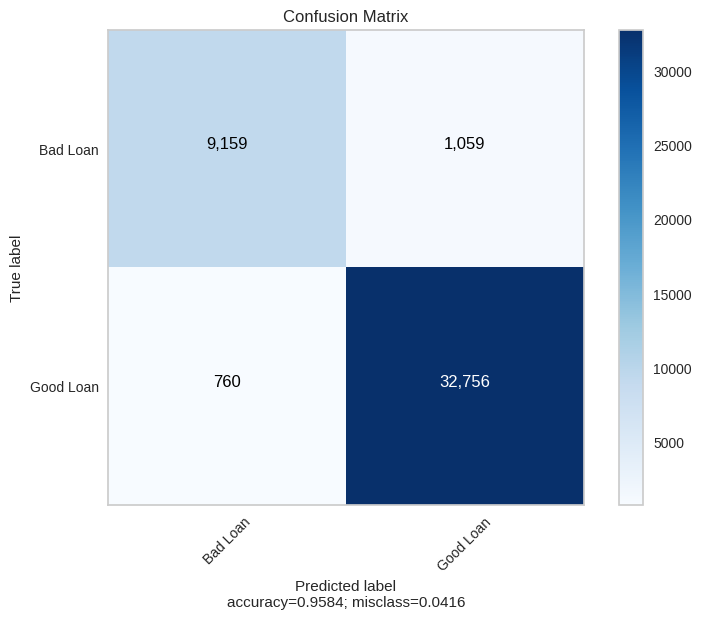

In [ ]:
# Define the hyperparameter distributions
params = {
    'max_depth': stats.randint(3, 10),
    'learning_rate': stats.uniform(0.5, 0.1),
    'subsample': stats.uniform(0.1, 0.9),
    'n_estimators':stats.randint(50, 500)
}

# Create an instance of XGBClassifier
xgb = XGBClassifier(random_state=42)

# Main pipeline for fitting.
xgb_model_HT = Pipeline([
    ('col_transform', ct),
     ('smt', smt),
      ('xgb_HT', RandomizedSearchCV(xgb, params, n_iter=10, cv=7, scoring='accuracy'))])

xgb_model_HT.fit(X_train, y_train)
y_pred_xgb = xgb_model_HT.predict_proba(X_val)
predicted = xgb_model_HT.predict(X_val)

# Print AUC, KS Score, and Classification Report
ks, auc = evaluate_ks_and_roc_auc(y_val, y_pred_xgb)
matrix = classification_report(y_val, predicted)
print("Classification Report XGBoost Classifier: \n", matrix)
cm = confusion_matrix(y_val, predicted)
target_names = ['Bad Loan', 'Good Loan']
plot_confusion_matrix(cm, target_names, title='Confusion Matrix', cmap=None, normalize=False)

In [ ]:
xgb_model_HT.steps[2][1].best_params_

{'learning_rate': 0.5289063031828417,
 'max_depth': 5,
 'n_estimators': 448,
 'subsample': 0.9927436309213458}

ROC AUC: 0.9901
KS: 0.8931 (p-value: 0.000e+00)
Classification report Logistic Regression: 
               precision    recall  f1-score   support

           0       0.92      0.90      0.91     10218
           1       0.97      0.98      0.97     33516

    accuracy                           0.96     43734
   macro avg       0.95      0.94      0.94     43734
weighted avg       0.96      0.96      0.96     43734



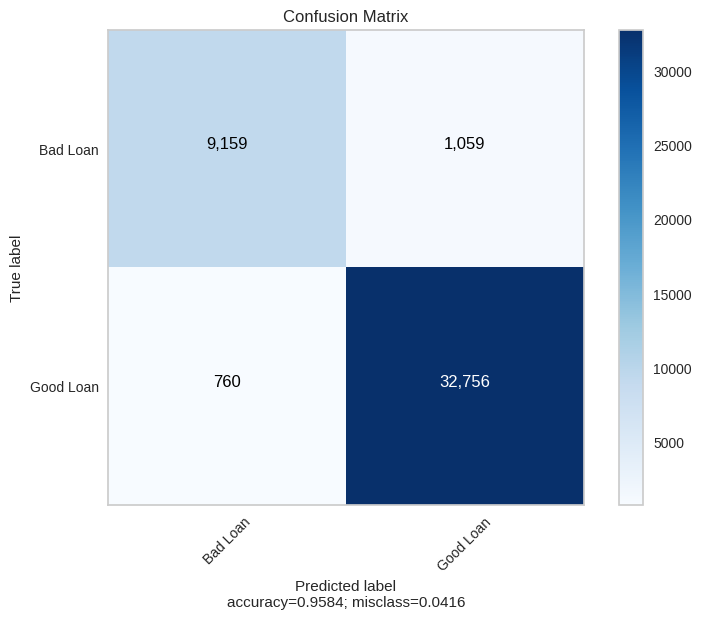

In [ ]:
# Create an instance of XGBClassifier
xgb = XGBClassifier(learning_rate=0.5289063031828417, max_depth=5,
                    n_estimators=448, subsample=0.9927436309213458,
                    random_state=42)

# Main pipeline for fitting.
xgb_model = Pipeline([
    ('col_transform', ct),
     ('smt', smt),
      ('xgb', xgb)])

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict_proba(X_val)
predicted = xgb_model.predict(X_val)

# Print AUC, KS Score, and Classification Report
ks, auc = evaluate_ks_and_roc_auc(y_val, y_pred_xgb)
matrix = classification_report(y_val, predicted)
print("Classification report Logistic Regression: \n", matrix)
cm = confusion_matrix(y_val, predicted)
target_names = ['Bad Loan', 'Good Loan']
plot_confusion_matrix(cm, target_names, title='Confusion Matrix', cmap=None, normalize=False)

# Model Interpretation

In [ ]:
feature_importance = pd.DataFrame()
feature_importance['features'] = X_train.columns
feature_importance['importance'] = xgb_model.named_steps['xgb'].feature_importances_

<Figure size 3000x1000 with 0 Axes>

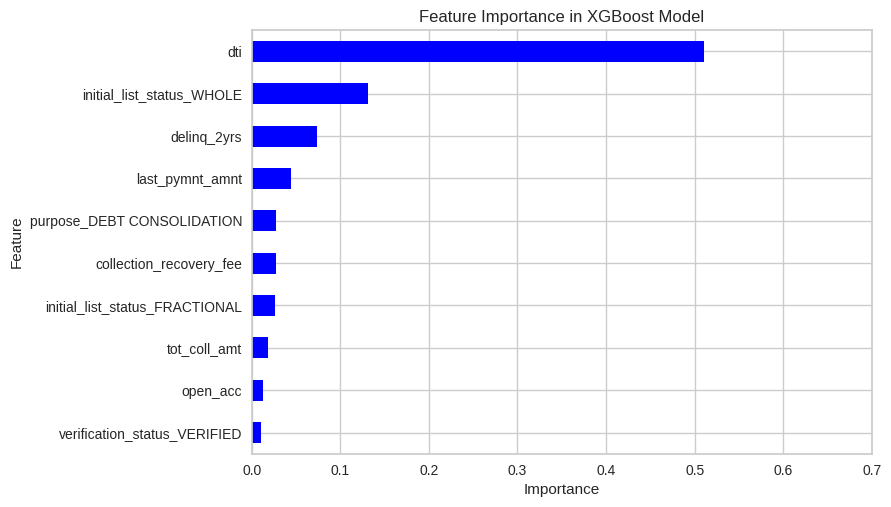

In [ ]:
plt.figure(figsize=(30,10))
plot = feature_importance.sort_values('importance', ascending=False).head(10).plot.barh(color='blue', legend=None)
plot.set_yticklabels(feature_importance.sort_values('importance', ascending=False).head(10).features)
plt.title("Feature Importance in XGBoost Model")
plt.xlim([0,0.7])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.gca().invert_yaxis()
plt.show()

Top 3 features importance in predicting credit risk (Good or Bad):

*   dti
*   initial_status_list_WHOLE
*   delinq_2yrs

